In [1]:
# Uncomment to use autoreload
%load_ext autoreload
%autoreload 2

import os
import os.path as osp
import sys
import torch
import numpy as np
from time import time
from omegaconf import OmegaConf
start = time()
import warnings
warnings.filterwarnings('ignore')

# torch.cuda.set_device(I_GPU)
DIR = os.path.dirname(os.getcwd())
ROOT = os.path.join(DIR, "..")
sys.path.insert(0, ROOT)
sys.path.insert(0, DIR)

from torch_points3d.utils.config import hydra_read
from torch_geometric.data import Data
from torch_points3d.core.multimodal.data import MMData, MMBatch
from torch_points3d.visualization.multimodal_data import visualize_mm_data
from torch_points3d.core.multimodal.image import SameSettingImageData, ImageData
from torch_points3d.datasets.segmentation.multimodal.scannet import ScannetDatasetMM
from torch_points3d.datasets.segmentation.scannet import CLASS_COLORS, CLASS_NAMES, CLASS_LABELS
from torch_points3d.metrics.segmentation_tracker import SegmentationTracker
from torch_points3d.datasets.segmentation import IGNORE_LABEL
from torch_points3d.metrics.scannet_segmentation_tracker import ScannetSegmentationTracker
from torch_points3d.metrics.colored_tqdm import Coloredtqdm as Ctq

from collections import defaultdict

from PIL import Image

import matplotlib.pyplot as plt 

%matplotlib inline

CLASS_COLORS[0] = (174.0, 199.0, 232.0)
CLASS_COLORS[-1] = (0, 0, 0)
import plotly.io as pio

#pio.renderers.default = 'jupyterlab'        # for local notebook
pio.renderers.default = 'iframe_connected'  # for remote notebook. Other working (but seemingly slower) options are: 'sphinx_gallery' and 'iframe'

import os
import os.path as osp
import copy
import torch
import hydra
import logging
import scipy.ndimage
import numpy as np
from PIL import Image
import open3d as o3d

# Import building function for model and dataset
from torch_points3d.datasets.dataset_factory import instantiate_dataset
from torch_points3d.models.model_factory import instantiate_model

# Import BaseModel / BaseDataset for type checking
from torch_points3d.models.base_model import BaseModel
from torch_points3d.datasets.base_dataset import BaseDataset

# Import from metrics
from torch_points3d.metrics.base_tracker import BaseTracker
from torch_points3d.metrics.colored_tqdm import Coloredtqdm as Ctq
from torch_points3d.metrics.model_checkpoint import ModelCheckpoint

# Utils import
from torch_points3d.utils.colors import COLORS
from torch_points3d.utils.wandb_utils import Wandb
from torch_points3d.utils.config import getattr_recursive
from torch_points3d.visualization import Visualizer
from torch_points3d.core.data_transform.transforms import PointcloudMerge
from torch_points3d.datasets.segmentation.scannet import CLASS_COLORS, CLASS_NAMES, CLASS_LABELS


log = logging.getLogger(__name__)

def get_seen_points(mm_data):
    ### Select seen points
    csr_idx = mm_data.modalities['image'][0].view_csr_indexing
    dense_idx_list = torch.arange(mm_data.modalities['image'][0].num_points).repeat_interleave(csr_idx[1:] - csr_idx[:-1])
    # take subset of only seen points without re-indexing the same point
    mm_data = mm_data[dense_idx_list.unique()]
    return mm_data

def get_mode_pred(data):
    pixel_validity = data.data.mvfusion_input[:, :, 0].bool()
    mv_preds = data.data.mvfusion_input[:, :, -1].long()
            
    valid_m2f_feats = []
    for i in range(len(mv_preds)):
        valid_m2f_feats.append(mv_preds[i][pixel_validity[i]])

    mode_preds = []
    for m2feats_of_seen_point in valid_m2f_feats:
        mode_preds.append(torch.mode(m2feats_of_seen_point.squeeze(), dim=0)[0])
    mode_preds = torch.stack(mode_preds, dim=0)
        
    return mode_preds

def get_random_view_pred(data):
    pixel_validity = data.data.mvfusion_input[:, :, 0].bool()
    mv_preds = data.data.mvfusion_input[:, :, -1].long()
            
    valid_m2f_feats = []
    for i in range(len(mv_preds)):
        valid_m2f_feats.append(mv_preds[i][pixel_validity[i]])

    selected_view_preds = []
    for m2feats_of_seen_point in valid_m2f_feats:
        selected_idx = torch.randint(low=0, high=m2feats_of_seen_point.shape[0], size=(1,))
        selected_pred = m2feats_of_seen_point[selected_idx].squeeze(0)
        selected_view_preds.append(selected_pred)
    selected_view_preds = torch.stack(selected_view_preds, dim=0)
        
    return selected_view_preds




MMData debug() function changed, please uncomment the 3rd assert line when doing inference without M2F features!
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# # model_name = 'MVFusion_small_6views' # fixed, problem was casting the pixel_validity mask to .long()

# # model_name = 'MVFusion_orig' # good

# # model_name = 'MVFusion_somehow_works' # good

# # model_name = 'MVFusion_3D_small_6views' # good
# # model_name = 'MVFusion_3D_small'


# ###################################################################
# if model_name == 'MVFusion_3D_small_6views' :
#     checkpoint_dir = ["/home/fsun/DeepViewAgg/outputs/MVFusion_3D_6_views_m2f_masks",
#                       "/home/fsun/DeepViewAgg/outputs/ViT_masks_3rd_run"]
#     models_config = 'segmentation/multimodal/Feng/mvfusion' 
# elif model_name == 'Deepset_3D':
#     checkpoint_dir = ["/home/fsun/DeepViewAgg/outputs/2023-02-05/23-15-04",
#                       "/home/fsun/DeepViewAgg/outputs/2023-01-23/12-57-16"]        
#     models_config = 'segmentation/multimodal/Feng/view_selection_experiment' 
# elif model_name == 'MVFusion_orig':
#     checkpoint_dir = ['/home/fsun/DeepViewAgg_31-10-22/DeepViewAgg/outputs/2023-02-11/22-17-12',
#                       '/home/fsun/DeepViewAgg/outputs/MVFusion_orig']
#     models_config = 'segmentation/multimodal/Feng/mvfusion_orig' 
# elif model_name == 'DeepSetAttention':
#     checkpoint_dir = ['/home/fsun/DeepViewAgg/outputs/2023-02-11/10-54-19',
#                       '/home/fsun/DeepViewAgg/outputs/2023-02-11/10-52-09']   # old: 'DeepSet_feats_labels_superconvergence'
#     models_config = 'segmentation/multimodal/Feng/view_selection_experiment' 
    
    
# elif model_name == 'MVFusion_small_6views':
#     models_config = 'segmentation/multimodal/Feng/view_selection_experiment' 
    
# elif model_name == 'MVFusion_somehow_works':
#     models_config = 'segmentation/multimodal/Feng/mvfusion_orig' 
    
# elif model_name == 'MVFusion_3D_small':
#     models_config = 'segmentation/multimodal/Feng/mvfusion' 



In [3]:
# Set your dataset root directory, where the data was/will be downloaded
DATA_ROOT = '/scratch-shared/fsun/dvata'

dataset_config = 'segmentation/multimodal/Feng/scannet-val-val.yaml'   
# dataset_config = 'segmentation/multimodal/Feng/scannet-neucon-smallres-m2f.yaml'   
models_config = 'segmentation/multimodal/Feng/mvfusion'    # model family
model_name = 'MVFusion_3D_small_6views_view_fusion_loss'                       # specific model


### Somehow broken loss backprop
# dataset_config = 'segmentation/multimodal/Feng/scannet-neucon-smallres-m2f.yaml'   
# models_config = 'segmentation/multimodal/Feng/mvfusion_orig'    # model family
# model_name = 'MVFusion_orig'                       # specific model

# Good
# dataset_config = 'segmentation/multimodal/Feng/scannet-neucon-smallres-m2f.yaml'   
# models_config = 'segmentation/multimodal/Feng/view_selection_experiment' 
# model_name = 'DeepSetAttention'

# ### Somehow broken loss backprop because the head is inside DVA_5_cls_7, and some other error with checkpointing
# dataset_config = 'segmentation/multimodal/Feng/scannet-neucon-smallres-m2f.yaml'   
# models_config = 'segmentation/multimodal/Feng/view_selection_experiment' 
# model_name = 'MVFusion'

# dataset_config = 'segmentation/multimodal/Feng/scannet-neucon-smallres-m2f.yaml'   
# models_config = 'segmentation/multimodal/Feng/view_selection_experiment' 
# model_name = 'MVFusion_small_6views'

# MVFusion_small_6views_orig

overrides = [
    'task=segmentation',
    f'data={dataset_config}',
    f'models={models_config}',
    f'model_name={model_name}',
    f'data.dataroot={DATA_ROOT}',
]

cfg = hydra_read(overrides)
OmegaConf.set_struct(cfg, False)  # This allows getattr and hasattr methods to function correctly
cfg.data.load_m2f_masks = True   # load Mask2Former predicted masks
cfg.data.m2f_preds_dirname = 'ViT_masks'
cfg.data.n_views = cfg.models[model_name].backbone.transformer.n_views
print("n_views: ", cfg.data.n_views)

# Dataset instantiation
start = time()
dataset = ScannetDatasetMM(cfg.data)
# print(dataset)|
print(f"Time = {time() - start:0.1f} sec.")

n_views:  6
Load predicted 2D semantic segmentation labels from directory  ViT_masks
initialize train dataset
initialize val dataset
Time = 2.1 sec.


In [4]:
# Create the model
print(f"Creating model: {cfg.model_name}")
model = instantiate_model(cfg, dataset)
print(model)

# # Load the checkpoint and recover the 'best_miou' model weights
# checkpoint = torch.load(f'{checkpoint_dir}/{model_name}.pt', map_location='cpu')
# model.load_state_dict_with_same_shape(checkpoint['models']['best_miou'], strict=False)

# Prepare the model for training
model = model.cuda()
print('Model loaded')

# Create train and validation loader
dataset.create_dataloaders(
    model,
    6,  # train bs
    True,  # shuffle
    17,
    False,
    train_only=False,
    val_only=False,
    test_batch_size=1
)

Creating model: MVFusion_3D_small_6views_view_fusion_loss
task:  segmentation.multimodal
tested_model_name:  MVFusion_3D_small_6views_view_fusion_loss
class_name:  MVFusionAPIModel
model_module:  torch_points3d.models.segmentation.multimodal.Feng.mvfusion_3d
name, cls of chosen model_cls:  MVFusionAPIModel <class 'torch_points3d.models.segmentation.multimodal.Feng.mvfusion_3d.MVFusionAPIModel'>
x feature dim:  {'FEAT': 3}
nc_in:  67
nc_in:  64
nc_in:  32
nc_in:  64
nc_in:  128
Return attention maps!
Enabling checkpointing for:  c
nc_in:  256
nc_in:  128
nc_in:  128
nc_in:  96
nc_in:  96
MVFusionAPIModel(
  (backbone): MVFusionSparseConv3dUnet(
    (inner_modules): ModuleList(
      (0): Identity()
    )
    (down_modules): ModuleList(
      (0): MultimodalBlockDown(
        (block_1): Identity()
        (block_2): Identity()
        (image): MVFusionUnimodalBranch(
          drop_3d=None
          drop_mod=None
          keep_last_view=False
          checkpointing=c
          (transfo

Model loaded


### Input data for quick hypothesis

In [5]:
scan_dir = "/scratch-shared/fsun/data/scannet/scans"
mapping_idx_to_scan_names = getattr(dataset.val_dataset, "MAPPING_IDX_TO_SCAN_{}_NAMES".format(dataset.val_dataset.split.upper()))
val_scans = list(mapping_idx_to_scan_names.values())

d = {}
for scene_id in val_scans:
    p = osp.join(scan_dir, scene_id, f'{scene_id}.txt')
    with open(p, 'r') as f:
        lines = f.readlines()
        sceneType = lines[-1].split("=")[-1].strip()
        d[scene_id] = sceneType

In [6]:
for scene_type, count in list(zip(*np.unique(list(d.values()), return_counts=True))):
    print(scene_type, count)

Apartment 9
Bathroom 43
Bedroom / Hotel 51
Bookstore / Library 15
Classroom 9
Conference Room 30
Copy/Mail Room 12
Dining Room 5
Game room 1
Hallway 3
Kitchen 22
Laundry Room 5
Living room / Lounge 41
Lobby 13
Misc. 5
Office 37
Stairs 2
Storage/Basement/Garage 9


In [7]:
# import pandas as pd

# datas = defaultdict(lambda: [])

# for scene_type in ['Bathroom', 'Living room / Lounge', 'Kitchen']:
#     for k, v in d.items():
#         if v == scene_type:
#             idx = list(mapping_idx_to_scan_names.keys())[list(mapping_idx_to_scan_names.values()).index(k)]
#             datas['scan_id'].append(k)
#             datas['scene_id'].append(k[:-3])
#             datas['loader_idx'].append(idx)
#             datas['scene_type'].append(scene_type)
            
#             count[k[:-3]] += 1
            
            
            
# df = pd.DataFrame.from_dict(datas)
# count

### Create a new dataset split using validation scenes

In [8]:
import pandas as pd

datas = defaultdict(lambda: [])
count = defaultdict(lambda: 0)

for scene_type in list(np.unique(list(d.values()))):
    for k, v in d.items():
        if v == scene_type:
            idx = list(mapping_idx_to_scan_names.keys())[list(mapping_idx_to_scan_names.values()).index(k)]
            count[k[:-3]] += 1
            
for scene_type in list(np.unique(list(d.values()))):
    for k, v in d.items():
        if v == scene_type:
            idx = list(mapping_idx_to_scan_names.keys())[list(mapping_idx_to_scan_names.values()).index(k)]
            
            if k[-2:] == '00':
                datas['scene_id'].append(k[:-3])
                datas['loader_idx'].append(idx)
                datas['num_scans'].append(count[k[:-3]])
                datas['scene_type'].append(scene_type)            
            
df = pd.DataFrame.from_dict(datas)
df

,scene_id,loader_idx,num_scans,scene_type
0,scene0046,11,3,Apartment
1,scene0207,66,3,Apartment
2,scene0231,75,3,Apartment
3,scene0084,25,3,Bathroom
4,scene0086,28,3,Bathroom
...,...,...,...,...
137,scene0700,301,3,Office
138,scene0357,121,2,Stairs
139,scene0307,93,3,Storage/Basement/Garage
140,scene0377,123,3,Storage/Basement/Garage


In [9]:
train_set = df.groupby("scene_type").sample(frac=0.66, random_state=2)
val_set = pd.concat([df, train_set]).drop_duplicates(keep=False)


(len(train_set), train_set.num_scans.sum()), (len(val_set), val_set.num_scans.sum())

((95, 207), (47, 105))

In [5]:
import shutil

# Create new train/val split in "/scratch-shared/fsun/dvata/scannet-val-val-split"
p = "/scratch-shared/fsun/dvata"

dataset_name = 'scannet-val-val-split'

dataset_p = osp.join(p, dataset_name)

os.makedirs(dataset_p, exist_ok=True)

processed_dir = osp.join(dataset_p, 'processed')
raw_dir = osp.join(dataset_p, 'raw')
for d in [processed_dir, raw_dir]:
    os.makedirs(d, exist_ok=True)
    
os.symlink("/scratch-shared/fsun/data/scannet/scans", osp.join(raw_dir, 'scans'))

meta_dir = osp.join(raw_dir, 'metadata')

if not os.path.exists(meta_dir):
    shutil.copytree("/scratch-shared/fsun/dvata/scannet-neucon-smallres-partial-subsampled/raw/metadata", meta_dir)


In [14]:
SOURCE_SPLIT = 'val'

for split, df in zip(['train', 'val'], [train_set, val_set]):
    # Get list of scan_ids
    res = [[scene_id + f"_0{i}" for i in range(count)] for scene_id, count in zip(df.scene_id, df.num_scans)]
    res = [item for sublist in res for item in sublist]
    # Write scan_ids to train and val splits
    with open(osp.join(meta_dir, f'scannetv2_{split}.txt'),'r+') as f:
        f.seek(0)
        for scan_id in res:
            f.write(f"{scan_id}\n")
        f.truncate()    
     
    for data_modality in ['processed_2d', 'raw']:

        source_dir = f"/scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/processed/{data_modality}_{SOURCE_SPLIT}"
        target_dir = osp.join(processed_dir, f'{data_modality}_{split}')


        if not os.path.exists(target_dir):
            os.makedirs(target_dir, exist_ok=True)
            # Symlink already processed 2d and 3d data to new dataset 
            for scan_id in res:
                os.symlink(osp.join(source_dir, f"{scan_id}.pt"), osp.join(target_dir, f"{scan_id}.pt"))






In [6]:
train_batch_list = []
# for i in [25, 28, 37, 14, 22, 62, 0, 17, 49]:
for i in [25, 37, 14, 62, 0, 49]:
    train_batch_list.append(dataset.val_dataset[i])
    
test_batch_list = []
for i in [11, 66, 77]:
    test_batch_list.append(dataset.val_dataset[i])

# import time

# for viz in train_batch_list:
#     visualize_mm_data(viz, figsize=1000, pointsize=3, voxel=0.1, show_2d=False, back='x', front='y', class_names=CLASS_NAMES, class_colors=CLASS_COLORS, alpha=0.3)
#     time.sleep(3)
    
# for viz in test_batch_list:
#     visualize_mm_data(viz, figsize=1000, pointsize=3, voxel=0.1, show_2d=False, back='x', front='y', class_names=CLASS_NAMES, class_colors=CLASS_COLORS, alpha=0.3)
#     time.sleep(3)


In [9]:
train_batch = MMBatch.from_mm_data_list(train_batch_list)
train_seen_batch = get_seen_points(train_batch)

test_batch = MMBatch.from_mm_data_list(test_batch_list)
test_seen_batch = get_seen_points(test_batch)

In [10]:
print(test_batch.y.unique(return_counts=True))
print(test_seen_batch.y.unique(return_counts=True))

(tensor([-1,  0,  1,  2,  3,  4,  6,  7,  8, 10, 11, 12, 13, 16, 17, 18, 19]), tensor([73154, 37637, 39053,  9178,  5756, 10448,  2386,  9446,  4527,   361,
         1093,  4864, 11030,   617,   502,  1704,  2362]))
(tensor([-1,  0,  1,  2,  3,  4,  6,  7,  8, 10, 11, 12, 13, 16, 17, 18, 19]), tensor([41971, 27662, 33859,  7847,  5192,  7857,  1575,  6844,  2867,   284,
          881,  3687,  6711,   454,   408,  1395,  1887]))


In [11]:
# with Ctq(dataset._train_loader) as loader:
#     for b in loader:
#         train_seen_batch = b
#         break
        
# with Ctq(dataset._val_loader) as loader:
#     for b in loader:
#         test_seen_batch = b
#         break

In [13]:
train_seen_batch = get_seen_points(train_seen_batch)

test_seen_batch = get_seen_points(test_seen_batch)


# Data visualization tools

### Modeling

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BaseNetwork(nn.Module):
#     def __init__(self):
        
    def backward(self):
        self.loss_seg.backward()


    @property
    def device(self):
        return next(self.parameters()).device
    
class Linear(BaseNetwork):
    def __init__(self, feat_indices, loss_func, num_views, num_classes, use_3d=False):
        super().__init__()
        
        self.feat_indices = feat_indices
        self.loss_fn = loss_func
        self.num_views = num_views
        self.num_classes = num_classes
        self.use_3d = use_3d
            
        # in_dim = n view feats + input label one hot
        feat_dim = len(self.feat_indices) * self.num_views + self.num_classes * self.num_views
        
        if self.use_3d:
            feat_dim += 3
        
        hidden_dim = 64
        self.fc1 = nn.Sequential(
            nn.Linear(feat_dim, hidden_dim),
#             nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
#             nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, self.num_classes)
        )
        
    def set_input(self, batch, device):
        self.input = batch.to(device)
        self.labels = batch.y.to(device)
        
    def forward(self, epoch=1):
        
        # Input data processing
        input_label = self.input.data.mvfusion_input[:, :, -1].long()
        input_label_one_hot = F.one_hot(input_label, num_classes=self.num_classes).flatten(1, 2)
        
        x = self.input.data.mvfusion_input[:, :, self.feat_indices].flatten(1, 2)
        
        if self.use_3d:
            data_3d = self.input.data.x
            x = torch.cat((data_3d, x, input_label_one_hot), axis=-1)
        else:
            x = torch.cat((x, input_label_one_hot), axis=-1)

        
        # Model forward
        out = self.fc1(x)
        
        # Loss and logits
        self.output = F.log_softmax(out, dim=-1)
        self.loss_seg = self.loss_fn(self.output, self.labels)

        
def one_step(model, optimizer, input, clip_gradient=False):
    optimizer.zero_grad()

    model.set_input(input.clone(), model.device)
    model.forward(epoch=1)

    model.backward()
    
    if clip_gradient:
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)

#     # Recover the predicted labels for visualization
#     batch.data.pred = model.output.detach().cpu().argmax(1)

    # the backward pass frees the graph memory, so there is no 
    # need for torch.no_grad in this training pass
    optimizer.step()

    return model.loss_seg.item()

def test_model(model, input):
    with torch.no_grad():
        model.set_input(input.clone(), model.device)
        model.forward(epoch=1)

# Bottom-up approach to view-fusion problem

- Test simple neural networks and measure losses/metrics. 
- Gradually increase model complexity, while inspecting under/overfitting.

In [38]:
LR = 0.01
WD = 0.01

FEAT_INDICES = []# [0, 1, 2, 3, 4, 5, 6, 7, 8] #9 # choose max 9

# Create models and load state_dicts    
loss_func = nn.NLLLoss(ignore_index=IGNORE_LABEL)
model = Linear(feat_indices=FEAT_INDICES, loss_func=loss_func, num_views=cfg.data.n_views, num_classes=dataset.num_classes)
model = model.cuda()

optim = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
# optim = torch.optim.SGD(model.parameters(), lr=LR, weight_decay=WD)


tracker = ScannetSegmentationTracker(dataset, 'val', False, False, ignore_label=IGNORE_LABEL)
tracker_base = ScannetSegmentationTracker(dataset, 'val', False, False, ignore_label=IGNORE_LABEL)
tracker_test = ScannetSegmentationTracker(dataset, 'val', False, False, ignore_label=IGNORE_LABEL) 
tracker_base_test = ScannetSegmentationTracker(dataset, 'val', False, False, ignore_label=IGNORE_LABEL) 


epoch duration:  1.745450735092163
Scores:   {'val_acc': 82.42182391873821, 'val_macc': 48.84089617577129, 'val_miou': 41.73919991251406}
Test Scores:   {'val_acc': 69.53294945617402, 'val_macc': 35.66326869761123, 'val_miou': 20.388309789970783}
epoch duration:  1.5609393119812012
Scores:   {'val_acc': 87.84616617663808, 'val_macc': 72.73016256395435, 'val_miou': 61.24917684361968}
Test Scores:   {'val_acc': 75.05575358742345, 'val_macc': 42.644730392233186, 'val_miou': 26.064344758257135}
epoch duration:  1.5609893798828125
Scores:   {'val_acc': 89.25719540540199, 'val_macc': 77.85353261881956, 'val_miou': 68.10515684671553}
Test Scores:   {'val_acc': 77.31621119337049, 'val_macc': 45.28670225906689, 'val_miou': 28.743930663190437}
epoch duration:  1.5615603923797607
Scores:   {'val_acc': 90.17847726956353, 'val_macc': 78.38267498948898, 'val_miou': 69.92790308386904}
Test Scores:   {'val_acc': 78.61027328397769, 'val_macc': 46.802049695292226, 'val_miou': 30.26370358730591}
epoch du

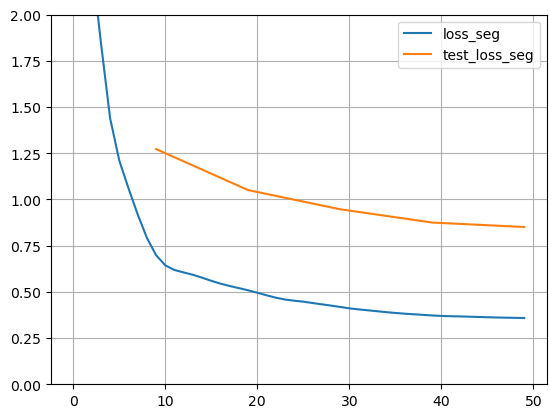

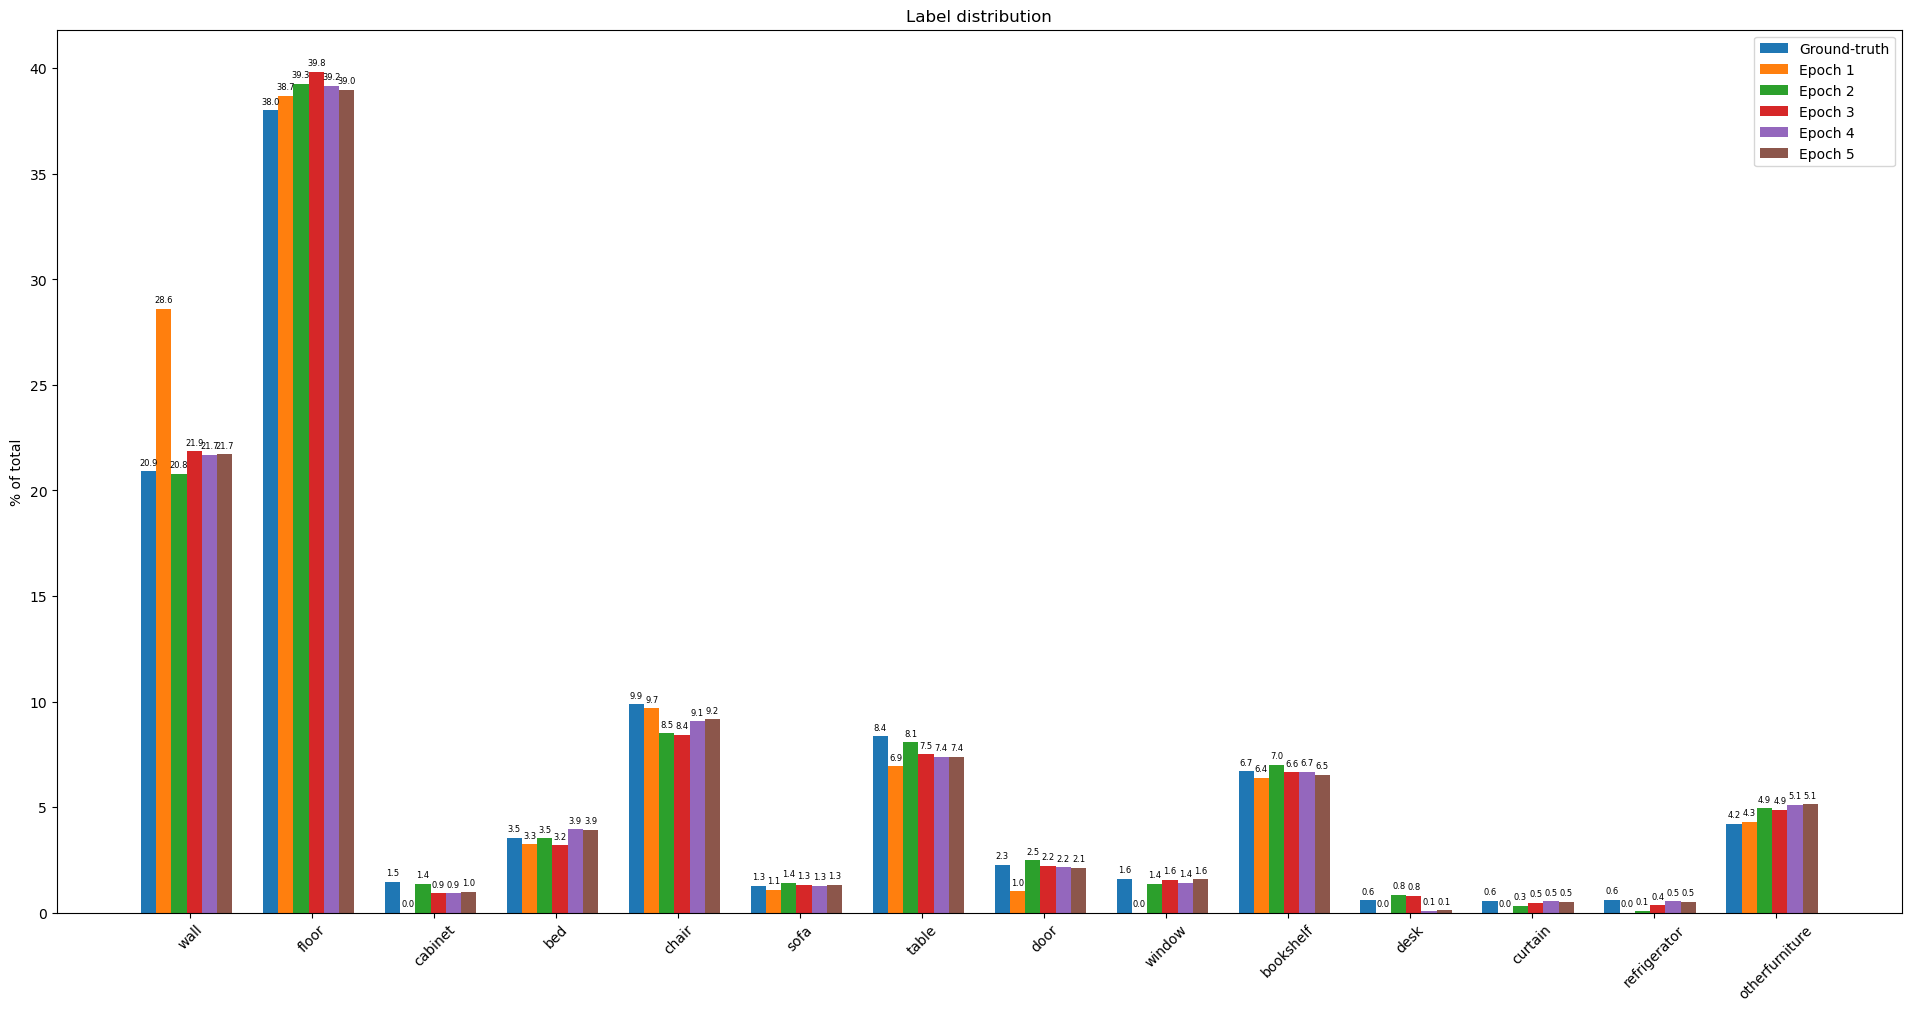

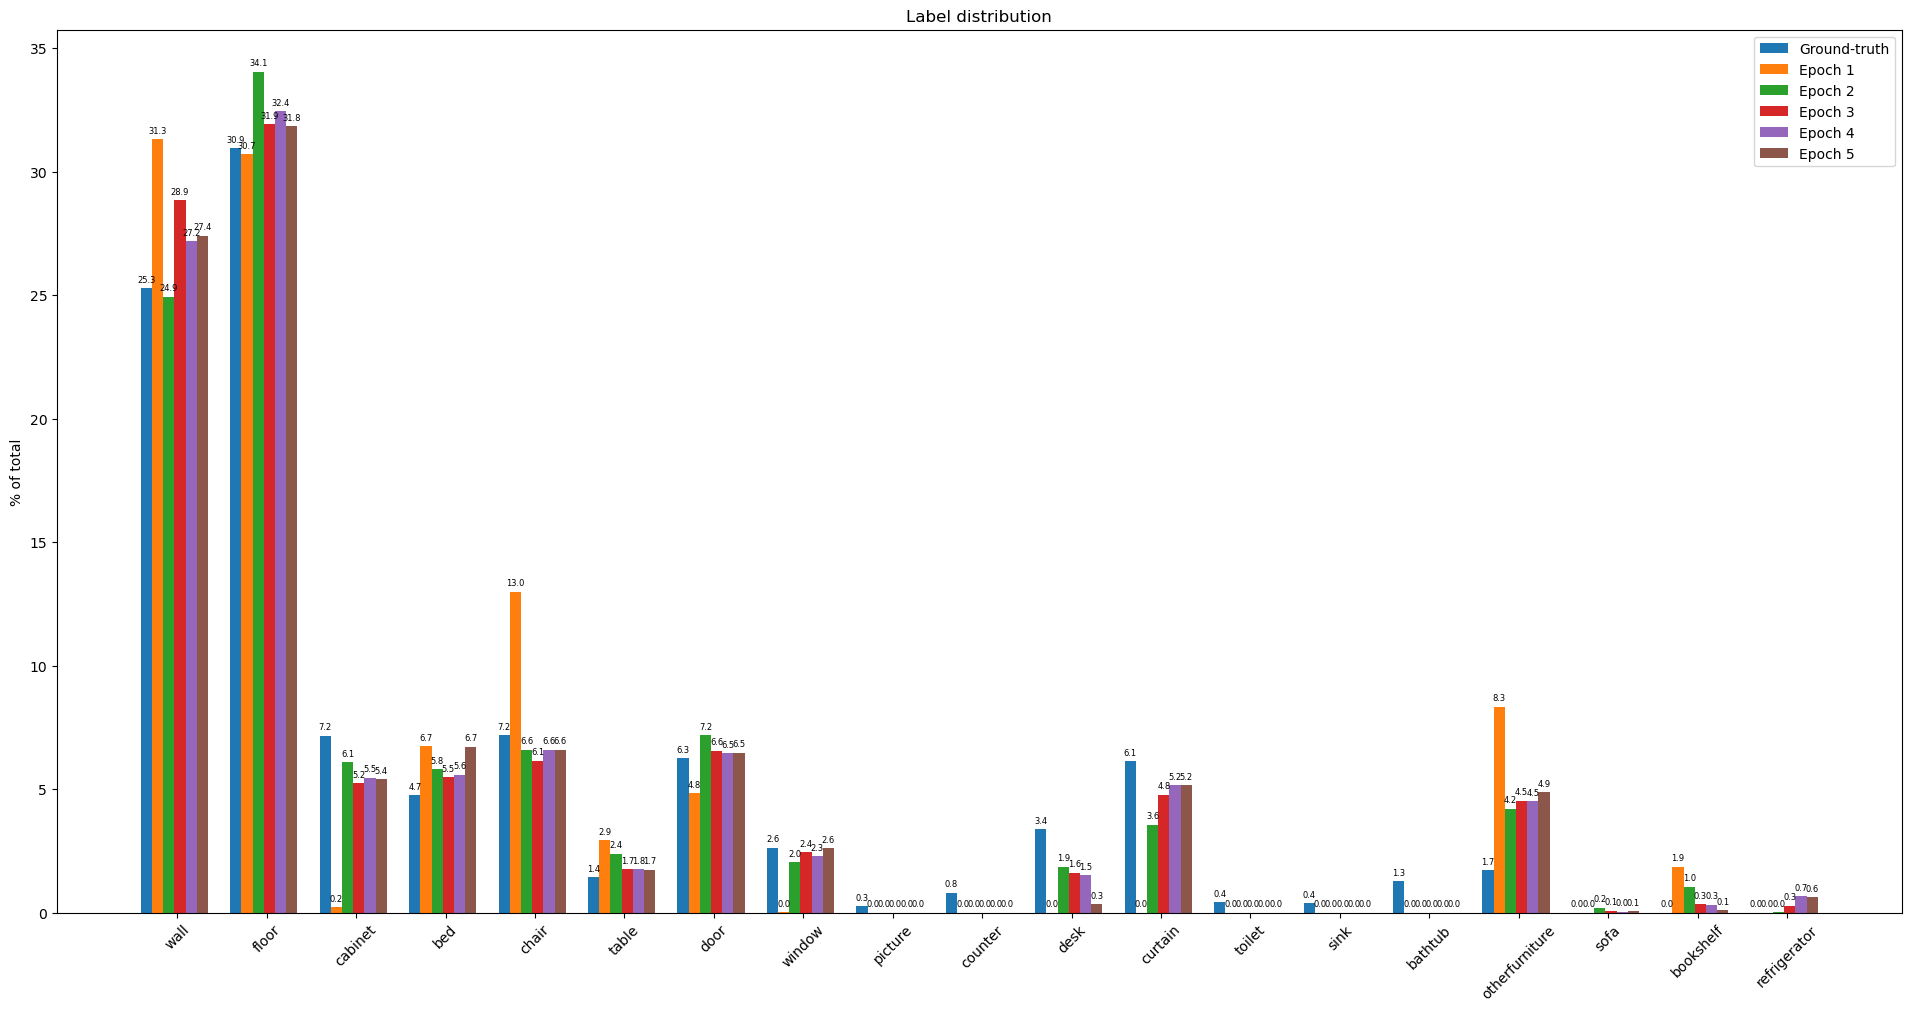

In [39]:
losses = []
test_losses = []

preds = []
test_preds = []


input_data = train_seen_batch
test_data = test_seen_batch

# for g in optim.param_groups:
#     g['lr'] = 0.1
n_iter = 10
n_epoch = 5

for _ in range(n_epoch):
    tracker.reset('val')

    torch.cuda.synchronize()
    s_time = time()

    for _ in range(n_iter):
        losses.append(one_step(model, optim, input_data, clip_gradient=False))
        
    torch.cuda.synchronize()
    print("epoch duration: ", time() - s_time)
    
    # Train score
    pred = model.output.detach().cpu().argmax(1)
    preds.append(pred) 
    tracker.track(gt_labels=input_data.y, pred_labels=pred, model=None)
#     tracker_base.track(gt_labels=input_data.y, pred_labels=get_mode_pred(input_data), model=None)
    
    # Test score
    test_model(model, test_data)
    test_losses.append(model.loss_seg.item())
    test_pred = model.output.detach().cpu().argmax(1)
    test_preds.append(test_pred) 
    tracker_test.track(gt_labels=test_data.y, pred_labels=test_pred, model=None)
#     tracker_base_test.track(gt_labels=test_data.y, pred_labels=get_mode_pred(test_data), model=None)
    
    
    
#     print(f"Baseline: {tracker_base.get_metrics()}")
    print(f"Scores:   {tracker.get_metrics()}")
    
#     print(f"Test Baseline: {tracker_base_test.get_metrics()}")
    print(f"Test Scores:   {tracker_test.get_metrics()}")

x = range(n_iter-1, n_iter * n_epoch, n_iter)
plt.plot(losses, label='loss_seg')
plt.plot(x, test_losses, label='test_loss_seg')
ax = plt.gca()
ax.set_ylim([0.0, 2.0])
plt.legend()
plt.grid()
plt.show()

plot_label_distribution(input_data, preds)
plot_label_distribution(test_data, test_preds)


epoch duration:  1.5606398582458496
Scores:   {'val_acc': 78.64431517626265, 'val_macc': 39.127501214720645, 'val_miou': 33.74786332619167}
Test Scores:   {'val_acc': 68.21862718215885, 'val_macc': 32.134014230790044, 'val_miou': 21.29407862138579}
epoch duration:  1.5700795650482178
Scores:   {'val_acc': 88.50422465103918, 'val_macc': 66.40018087031463, 'val_miou': 53.82287668468819}
Test Scores:   {'val_acc': 72.7246138378576, 'val_macc': 38.197367691171124, 'val_miou': 23.1683473907731}
epoch duration:  1.5440726280212402
Scores:   {'val_acc': 89.92242502984465, 'val_macc': 75.21591450115636, 'val_miou': 66.99878575543343}
Test Scores:   {'val_acc': 74.99162172866588, 'val_macc': 41.21140475765881, 'val_miou': 25.47447976158108}
epoch duration:  1.5427064895629883
Scores:   {'val_acc': 90.9871298948372, 'val_macc': 79.20713627062341, 'val_miou': 70.6443299260015}
Test Scores:   {'val_acc': 76.39178320080431, 'val_macc': 43.10557546039413, 'val_miou': 27.01114339822444}
epoch duratio

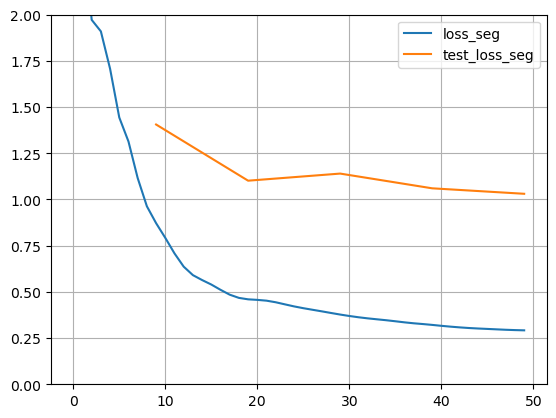

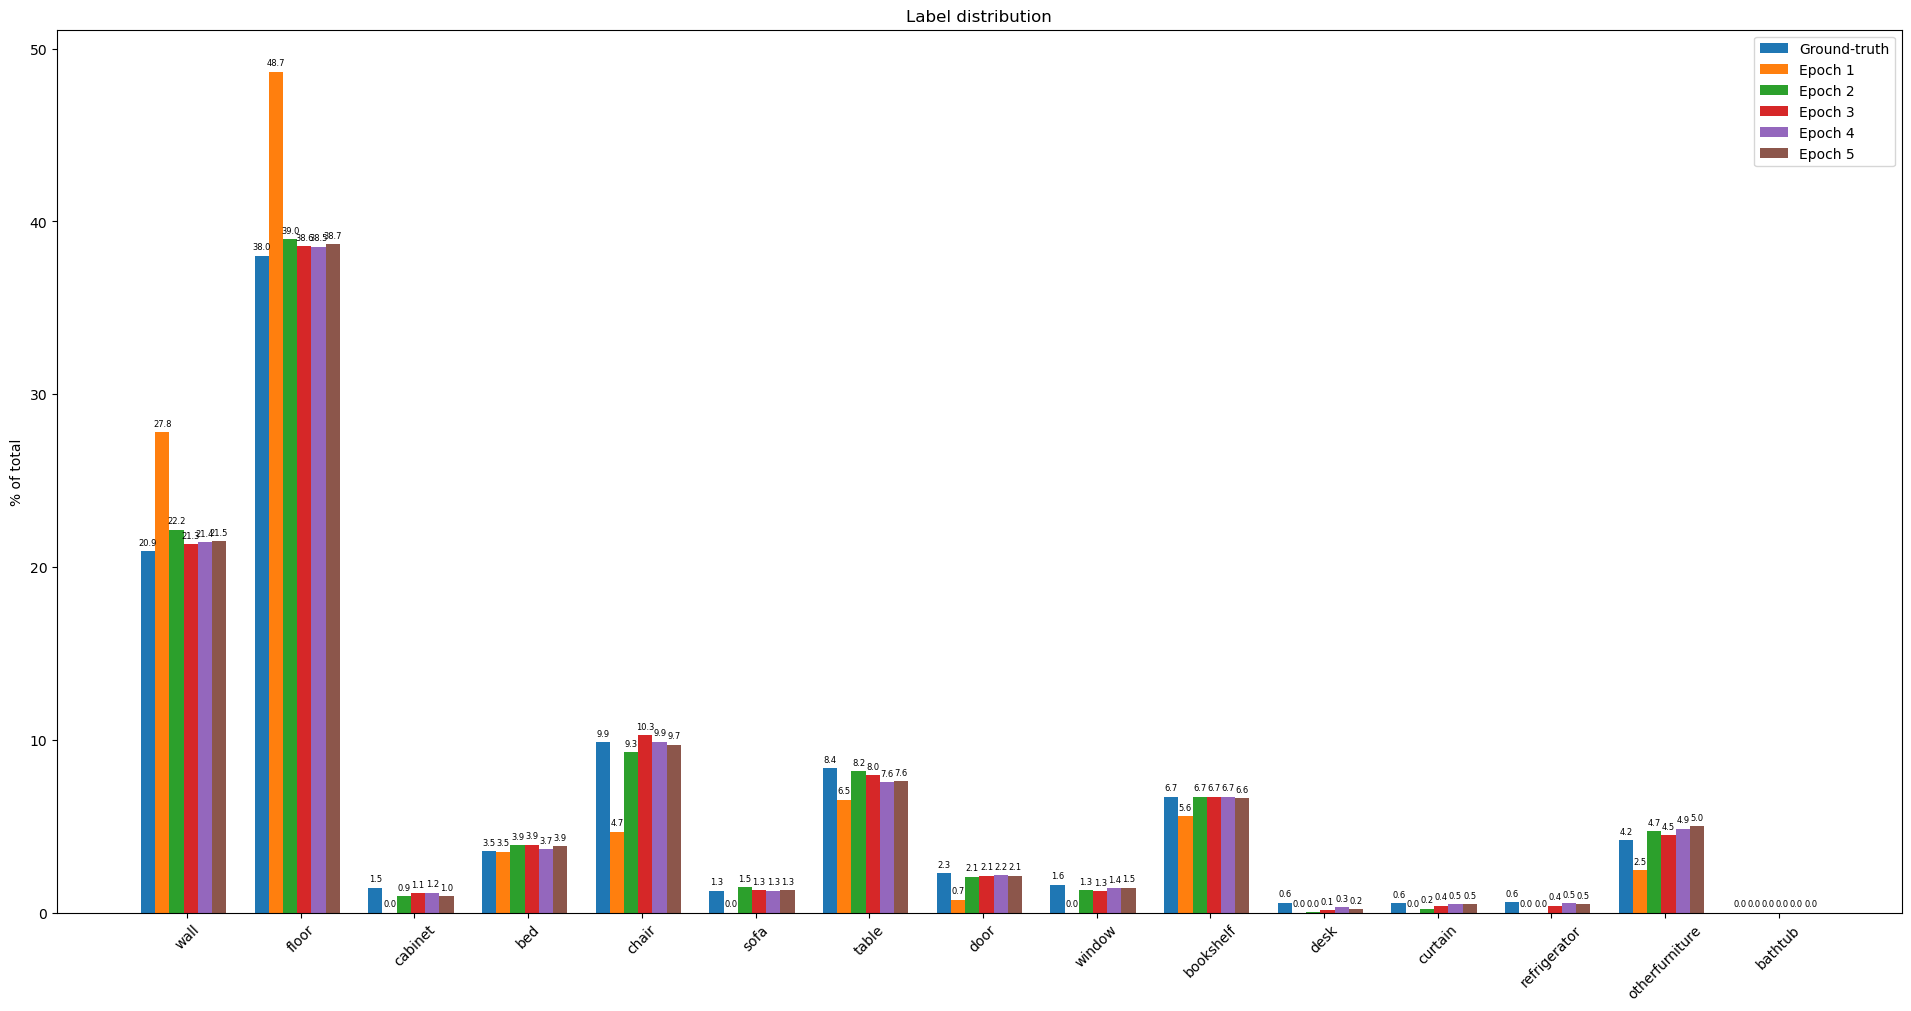

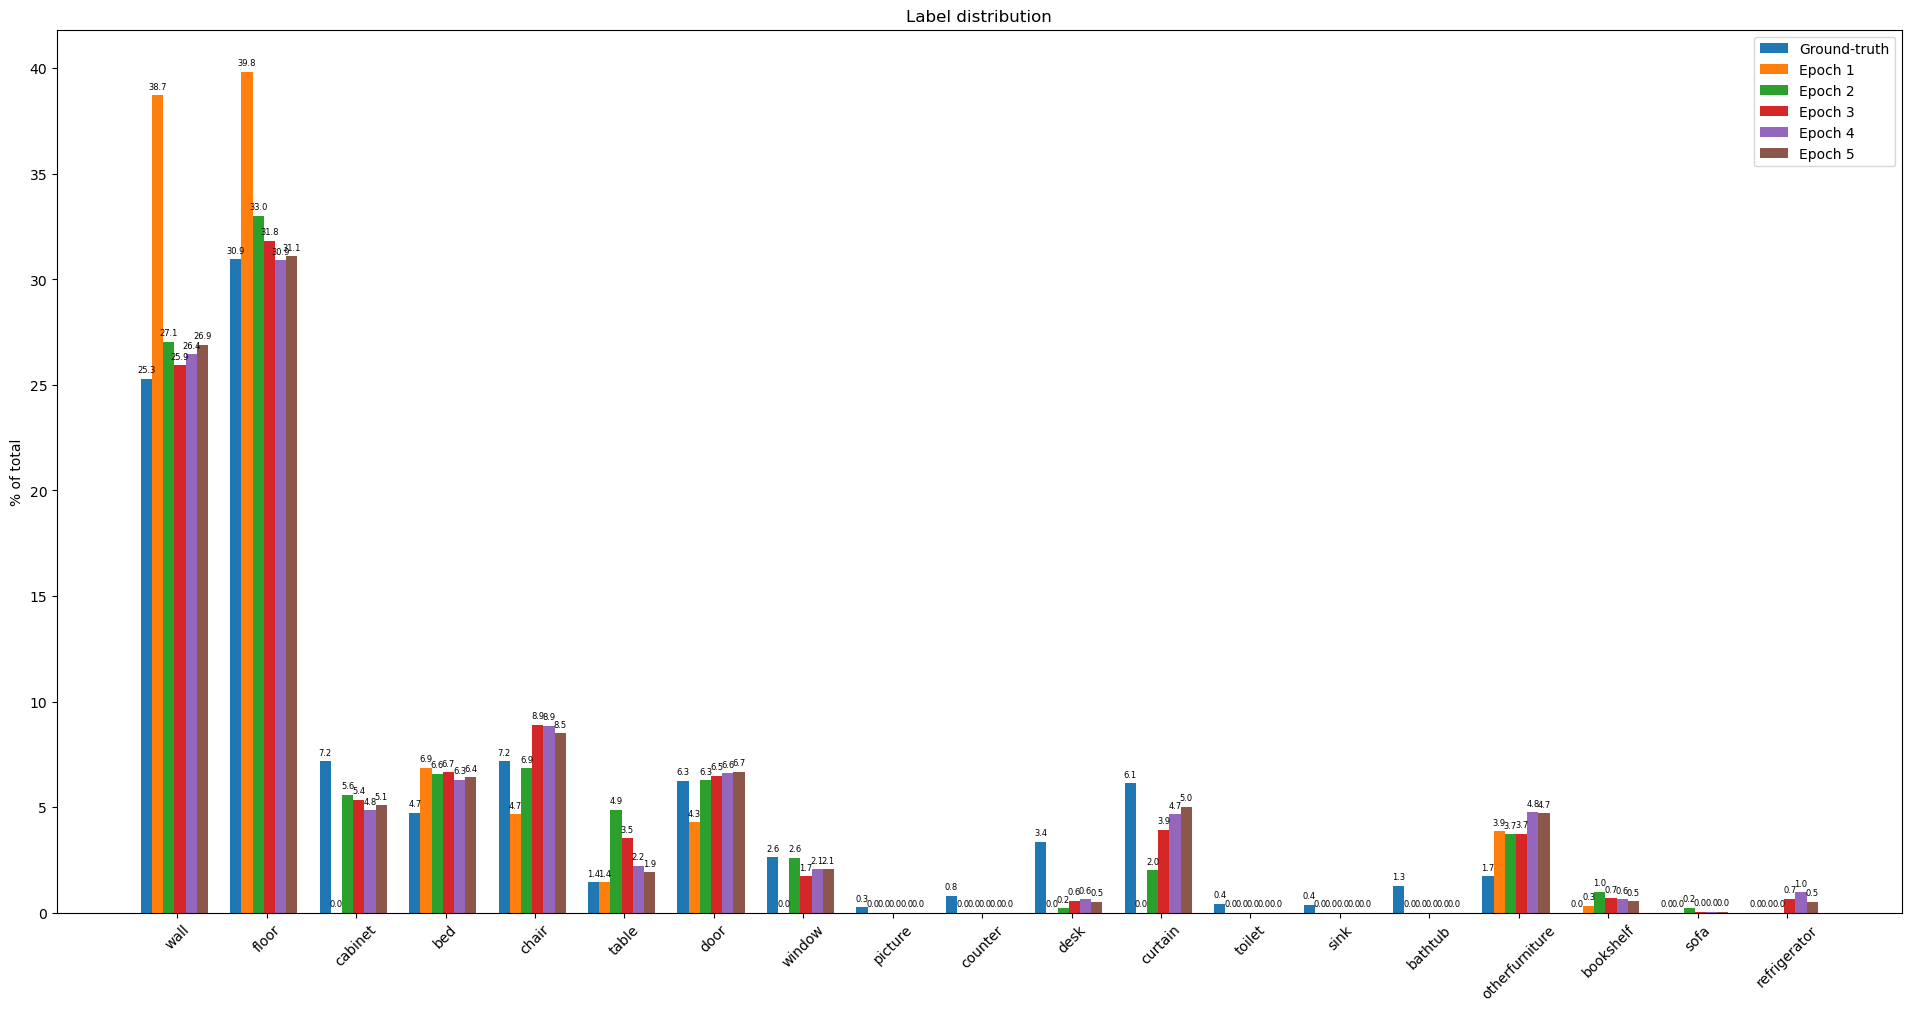

epoch duration:  3.093865394592285
Scores:   {'val_acc': 91.77985327480039, 'val_macc': 84.84628570962711, 'val_miou': 77.24721690418663}
Test Scores:   {'val_acc': 78.03326007806606, 'val_macc': 63.404750443983374, 'val_miou': 52.039063748104816}
epoch duration:  3.092470407485962
Scores:   {'val_acc': 91.91047209373127, 'val_macc': 85.04245502880924, 'val_miou': 77.76090995150925}
Test Scores:   {'val_acc': 78.27707984824133, 'val_macc': 63.697108953848605, 'val_miou': 52.38947597949715}
epoch duration:  3.096604108810425
Scores:   {'val_acc': 91.93797079245357, 'val_macc': 85.4012465866885, 'val_miou': 78.05452052244391}
Test Scores:   {'val_acc': 78.36217987265975, 'val_macc': 63.871833148617355, 'val_miou': 52.56905484271957}
epoch duration:  3.0976104736328125
Scores:   {'val_acc': 91.94419073621218, 'val_macc': 85.4875251702467, 'val_miou': 78.10670462926004}
Test Scores:   {'val_acc': 78.40705327953992, 'val_macc': 63.969371759992924, 'val_miou': 52.66243929764431}
epoch durati

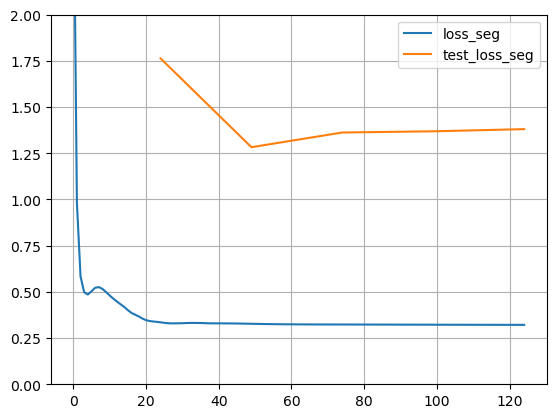

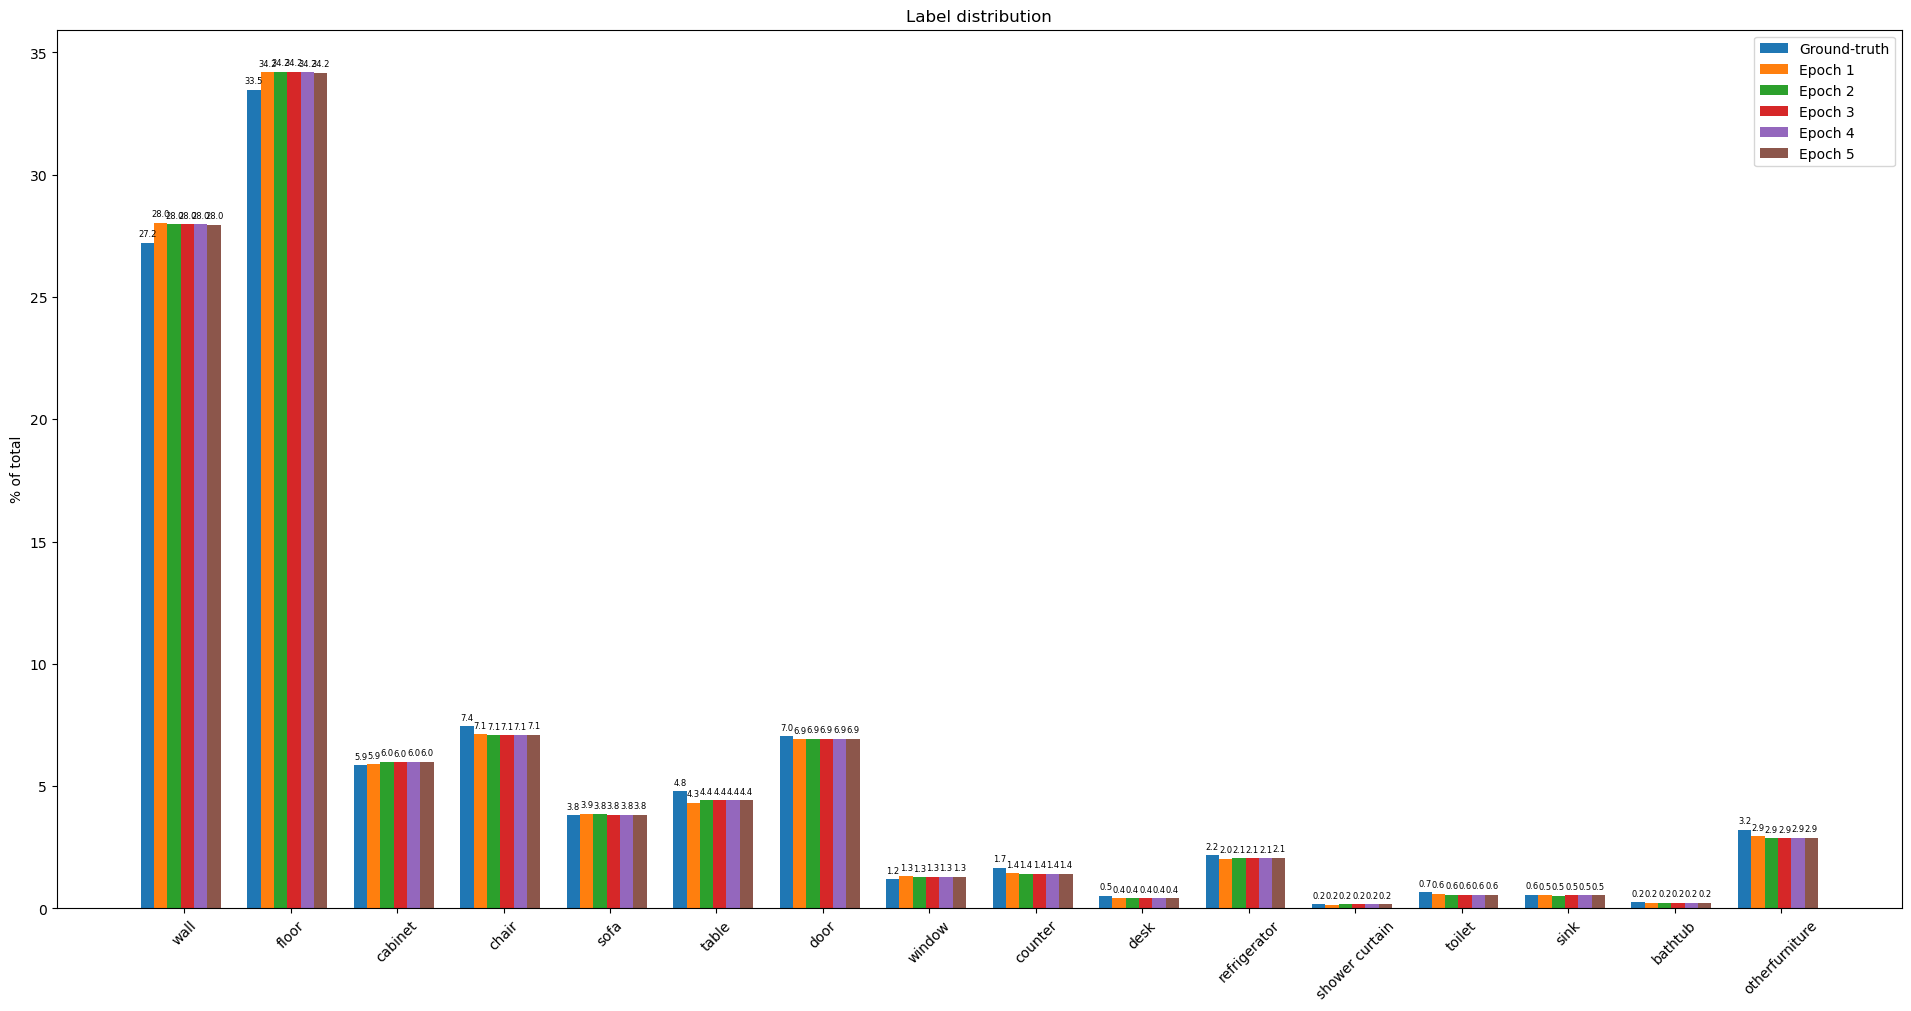

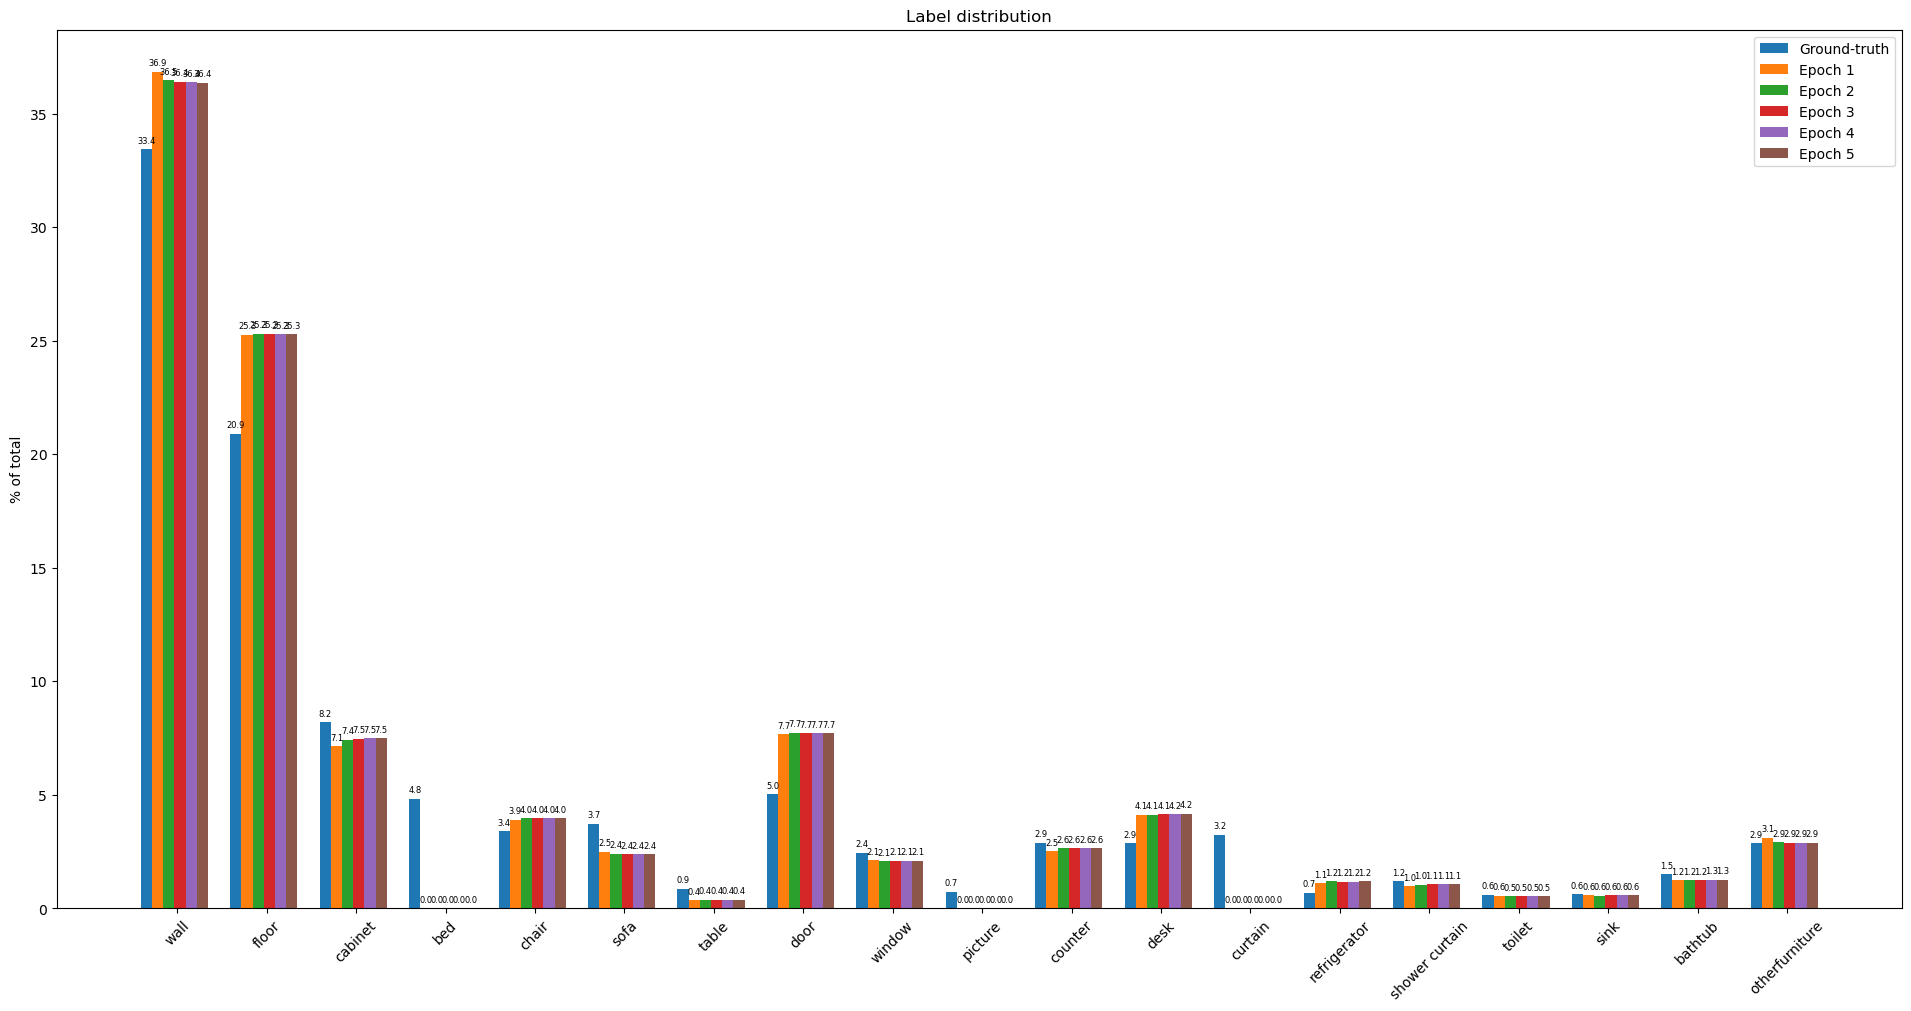

In [208]:
# Linear, input_preds but no other features

In [191]:
# 5 bars - > -1.0
# 6 bars -> -1.5
# 7 bars -> -2.0

In [22]:
from collections import defaultdict

def plot_label_distribution(data, preds):
        
    if isinstance(preds, list):
        preds = torch.vstack(preds)
        
    mask_ignore = data.y != -1
    pred_labels = preds[:, mask_ignore]
    gt_labels = data.y[mask_ignore]
        

    # Defining the dict
    d = defaultdict(lambda: np.zeros((1 + pred_labels.shape[0])))
            
    # Add gt values
    unique = gt_labels.unique(return_counts=True)        
    for k, v in list(zip(*unique)):
        d[k.item()][0] = v.item()
            
    # Add predicted labels of each epoch
    for i, labels in enumerate(pred_labels):
        unique = labels.unique(return_counts=True)        
        for k, v in list(zip(*unique)):
            d[k.item()][i+1] = v.item()   # idx 0 = gt, idx 1 = 1st epoch
            
    values = np.vstack(list(d.values()))
    
    # Normalize values
    for i in range(values.shape[1]):
        values[:, i] = values[:, i] / values[:, i].sum() * 100

#     values = values / values.sum() * 100
    
    values_dict = {}
    values_dict["Ground-truth"] = values[:, 0]
    for i in range(1, values.shape[1], 1):        
        values_dict[f"Epoch {i}"] = values[:, i]

    class_indices = list(d.keys())

    x = np.arange(len(class_indices))  # the label locations
    width = 0.125  # the width of the bars
    multiplier = -2 * (values.shape[1] + 1) * width # (7+x) * 0.125 = 2.0

    fig, ax = plt.subplots(figsize=(19, 10), constrained_layout=True)

    for attribute, measurement in values_dict.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, padding=3, labels=['%.1f' % m for m in measurement], fontsize=6)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('% of total')
    ax.set_title(f'Label distribution')
    ax.legend(loc='upper right')

    # ax.set_ylim(0, 250)
#     ax.set_yscale('log')

    locs, labels = plt.xticks()  # Get the current locations and labels.
    plt.xticks(x + width, np.array(CLASS_NAMES)[class_indices],
           rotation=45)  # Set text labels and properties.

    plt.show()

### Model behavior analysis

In [19]:
batch.modalities['image'][0].get_mapped_m2f_features().unique()

tensor([ 0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 12, 13, 15, 16, 17, 18, 19],
       dtype=torch.uint8)

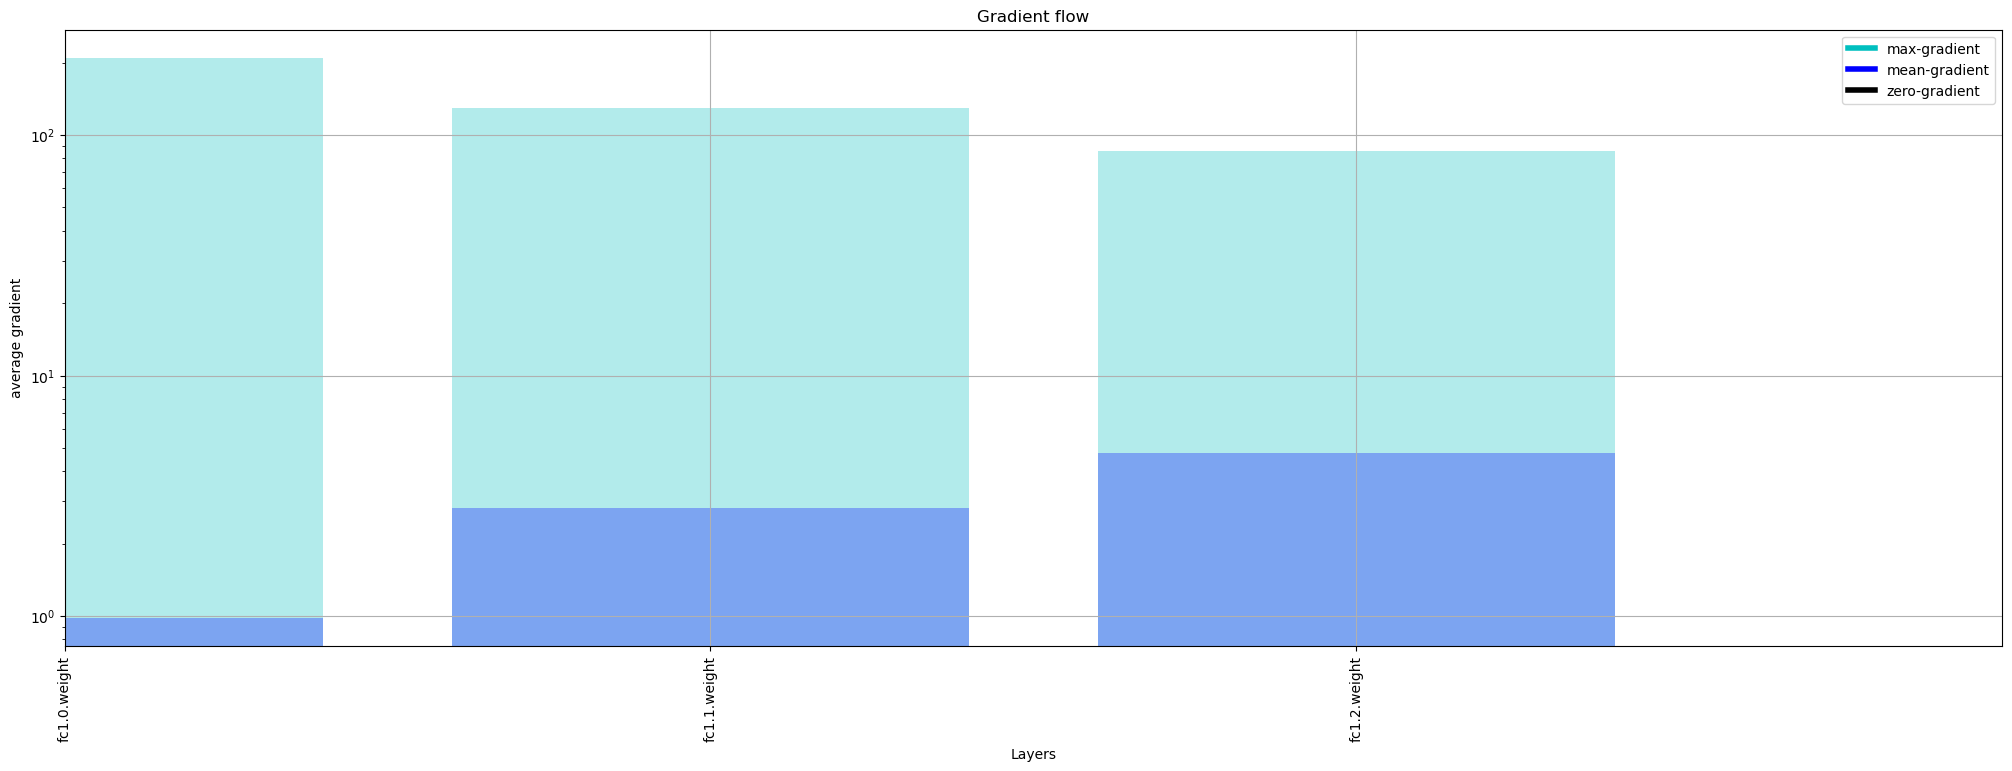

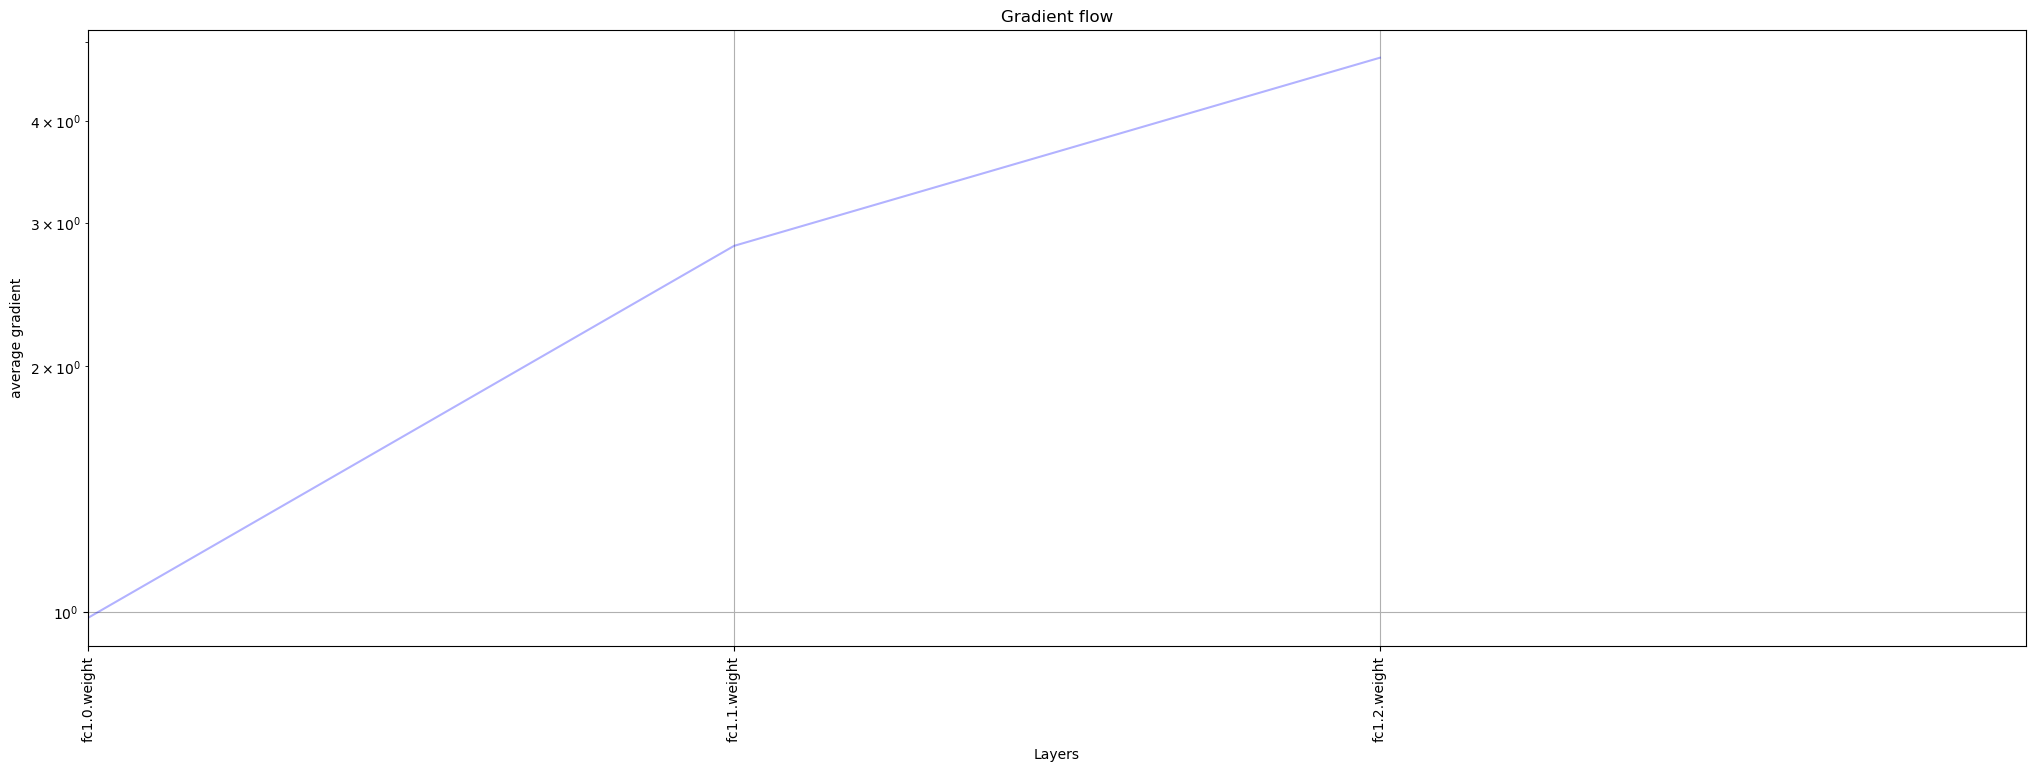

In [280]:
def plot_grad_flow_v2(named_parameters):
    from matplotlib.pyplot import Line2D
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    
    count = 0
    for n, p in named_parameters:
        count += 1
        if count > 33333:
            break
        if(p.requires_grad) and ("bias" not in n) and p.grad is not None:
            layers.append(n)
            ave_grads.append(p.grad.cpu().abs().mean())
            max_grads.append(p.grad.cpu().abs().max())
            
    plt.figure(figsize=(25, 8))
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.3, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.3, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
#     plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    plt.yscale("log")
    plt.show()
    
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.cpu().abs().mean())
    plt.figure(figsize=(25, 8))
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.yscale("log")
    plt.show()
    
model.set_input(test_seen_batch, model.device)
model.forward(epoch=1)
model.backward()
    
plot_grad_flow_v2(model.named_parameters())

plot_grad_flow(model.named_parameters())


In [17]:

    
    
s_time = time()


for i in range(100):
    losses.append(one_step(model, optim, return_view_loss=False))

print("100 iterations duration: ", time() - s_time)

# 300 iterations
# MVFusion_3D_small_6views with checkpointing: 108.3028724193573
# without: 95.99804043769836

tensor(2.8897, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1915, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4422, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9208, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8323, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7978, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7036, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4842, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2056, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2113, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0959, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0116, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8855, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7957, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7021, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6140, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5526, device='cuda:0', grad_fn=

# BatchNorm vs LayerNorm in Transformer view-fusion

In [7]:
batch_list = []
for i in [15, 30, 45, 60]:
    batch_list.append(dataset.val_dataset[i])

batch = MMBatch.from_mm_data_list(batch_list)
batch


loading gt mask from :  label-filt-scannet20
loading gt mask from :  label-filt-scannet20
loading gt mask from :  label-filt-scannet20
loading gt mask from :  label-filt-scannet20


MMBatch(
    data = Batch(batch=[222630], coords=[222630, 3], grid_size=[4], id_scan=[4], mapping_index=[222630], mvfusion_input=[156927, 6, 10], origin_id=[222630], pos=[222630, 3], ptr=[5], rgb=[222630, 3], x=[222630, 3], y=[222630])
    image = ImageBatch(num_settings=1, num_views=363, num_points=222630, device=cpu)
)

In [8]:
# for i in range(4):
#     model.backbone.fusion.fusion.transformer_layers[i].use_batch_norm = True
    
#     print(model.backbone.fusion.fusion.transformer_layers[i].use_batch_norm)

In [9]:
optim = torch.optim.Adam(model.parameters(), lr=0.01)
losses = []

s_time = time()
for i in range(5):
    losses.append(one_step(model, optim, return_view_loss=False))

print("5 iterations duration: ", time() - s_time)


self.training is True -> culling max n seen points
torch.Size([50000, 6, 10])
Going through checkpoint
tensor(3.1320, device='cuda:0', grad_fn=<NllLossBackward0>)
self.training is True -> culling max n seen points
torch.Size([50000, 6, 10])
Going through checkpoint
tensor(2.4015, device='cuda:0', grad_fn=<NllLossBackward0>)
self.training is True -> culling max n seen points
torch.Size([50000, 6, 10])
Going through checkpoint
tensor(2.1432, device='cuda:0', grad_fn=<NllLossBackward0>)
self.training is True -> culling max n seen points
torch.Size([50000, 6, 10])
Going through checkpoint
tensor(2.3187, device='cuda:0', grad_fn=<NllLossBackward0>)
self.training is True -> culling max n seen points
torch.Size([50000, 6, 10])
Going through checkpoint
tensor(2.0887, device='cuda:0', grad_fn=<NllLossBackward0>)
5 iterations duration:  12.992530822753906


In [ ]:

self.training is True -> culling max n seen points
torch.Size([50000, 6, 10])
Going through checkpoint
tensor(3.1558, device='cuda:0', grad_fn=<NllLossBackward0>)
self.training is True -> culling max n seen points
torch.Size([50000, 6, 10])
Going through checkpoint
tensor(2.3559, device='cuda:0', grad_fn=<NllLossBackward0>)
self.training is True -> culling max n seen points
torch.Size([50000, 6, 10])
Going through checkpoint
tensor(2.3728, device='cuda:0', grad_fn=<NllLossBackward0>)
self.training is True -> culling max n seen points
torch.Size([50000, 6, 10])
Going through checkpoint
tensor(2.2022, device='cuda:0', grad_fn=<NllLossBackward0>)
self.training is True -> culling max n seen points
torch.Size([50000, 6, 10])
Going through checkpoint
tensor(2.0270, device='cuda:0', grad_fn=<NllLossBackward0>)
5 iterations duration:  13.026421785354614

In [10]:
# # With checkpointing
# loss_seg, loss_cross_entropy, loss_view_fusion = list(map(list, zip(*losses)))

# plt.plot(loss_seg, label='loss_seg')
# plt.plot(loss_cross_entropy, label='loss_cross_entropy')
# plt.plot(loss_view_fusion, label='loss_view_fusion')

# ax = plt.gca()
# # ax.set_ylim([0.0, 1.0])

# plt.legend()
# plt.show()

In [11]:
# # Without checkpointing
# loss_seg, loss_cross_entropy, loss_view_fusion = list(map(list, zip(*losses)))

# plt.plot(loss_seg, label='loss_seg')
# plt.plot(loss_cross_entropy, label='loss_cross_entropy')
# plt.plot(loss_view_fusion, label='loss_view_fusion')

# ax = plt.gca()
# # ax.set_ylim([0.0, 1.0])

# plt.legend()
# plt.show()

In [14]:
# # loss_seg, loss_cross_entropy, loss_view_fusion = list(map(list, zip(*losses)))

# # loss_seg, loss_cross_entropy = list(map(list, zip(*losses)))

# plt.plot(losses, label='loss_seg')


# # plt.plot(loss_seg, label='loss_seg')
# # plt.plot(loss_cross_entropy, label='loss_cross_entropy')
# # plt.plot(loss_view_fusion, label='loss_view_fusion')

# ax = plt.gca()
# # ax.set_ylim([0.0, 1.0])

# plt.legend()
# plt.show()

In [13]:
model._use_view_fusion_loss# = False
# model._view_fusion_loss_weight = 0.01

False

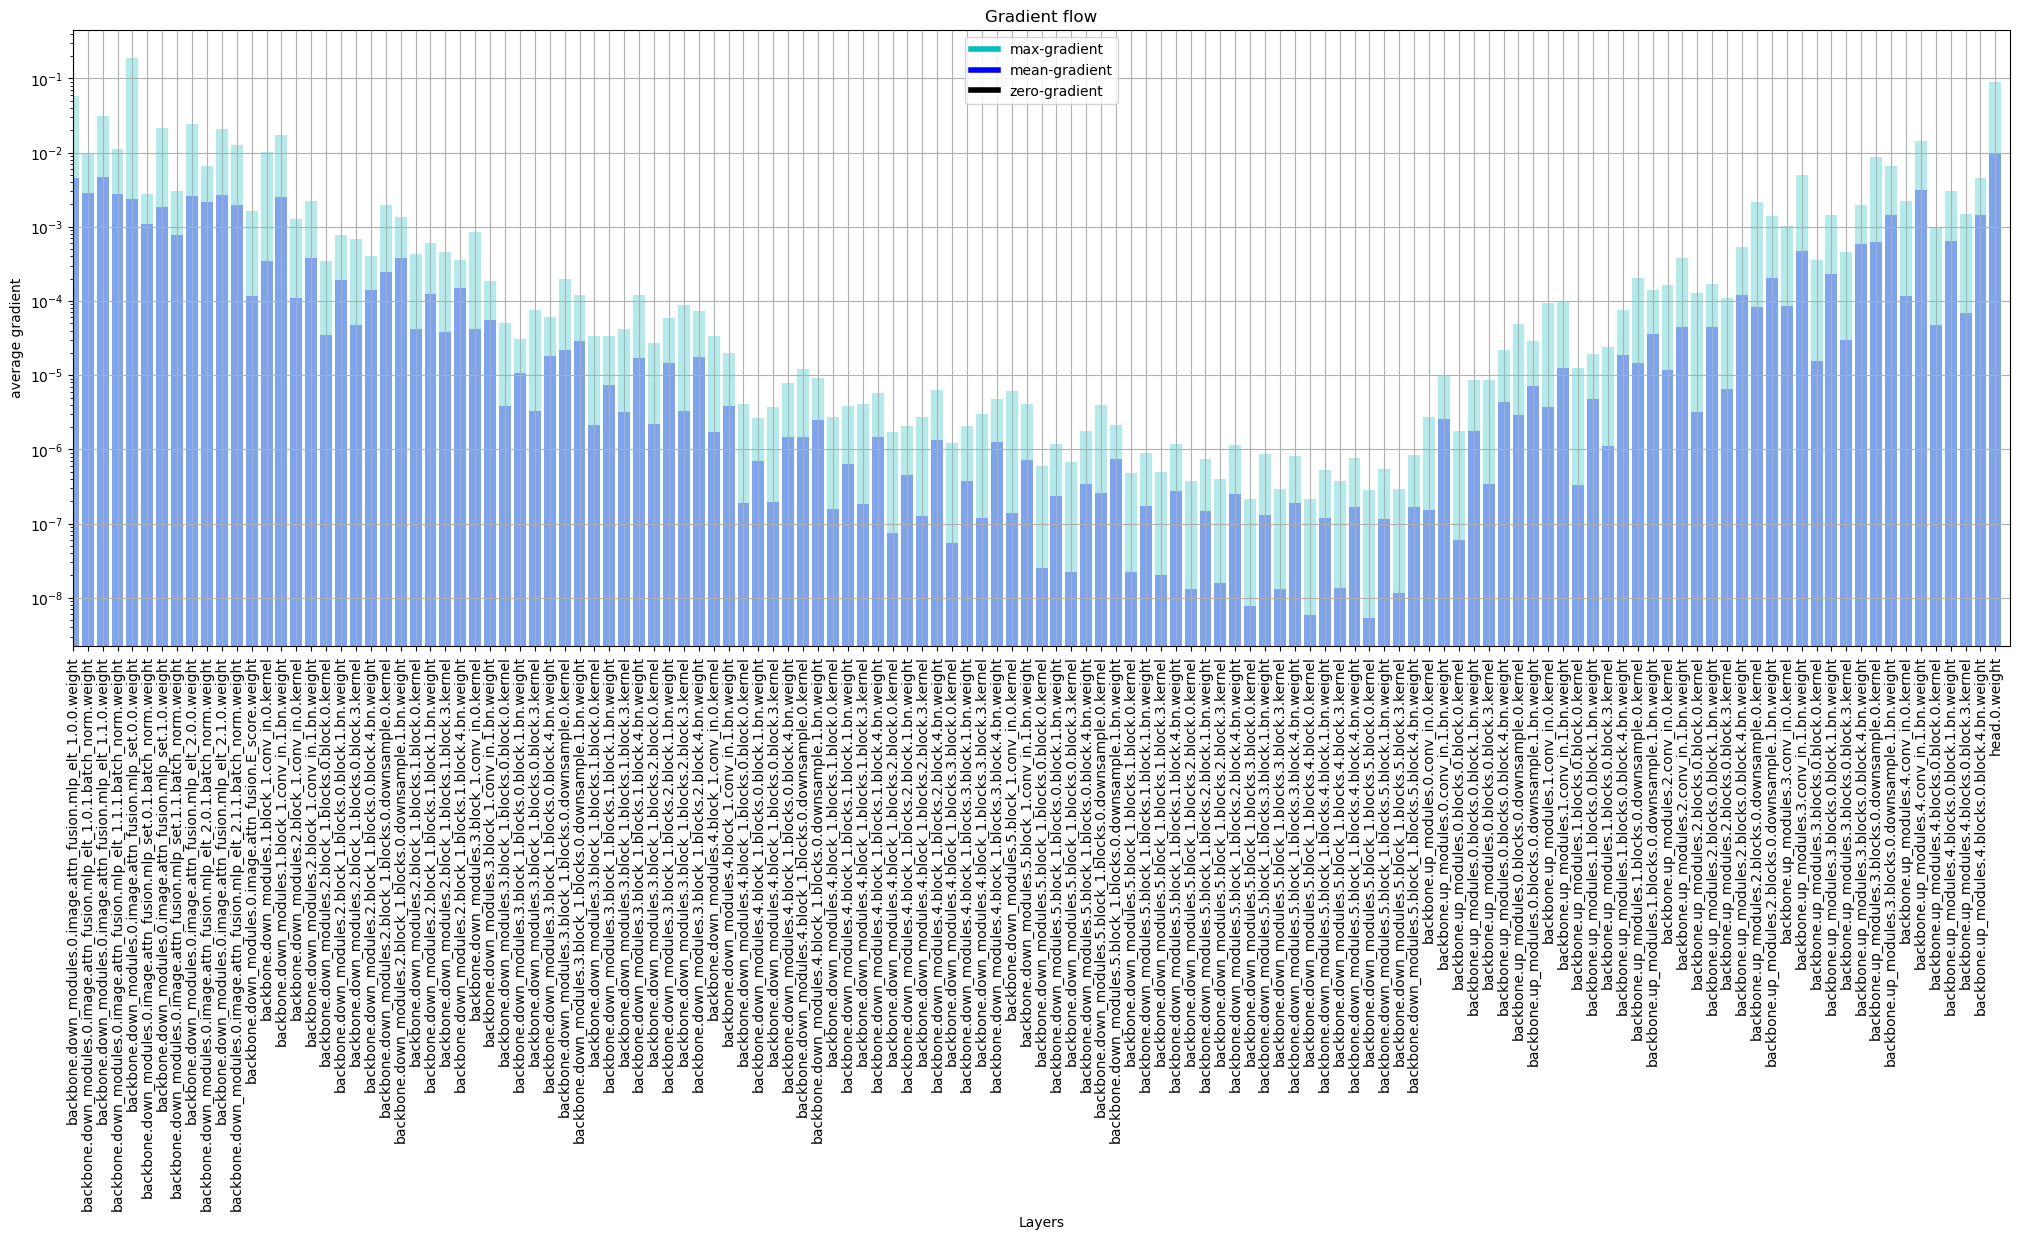

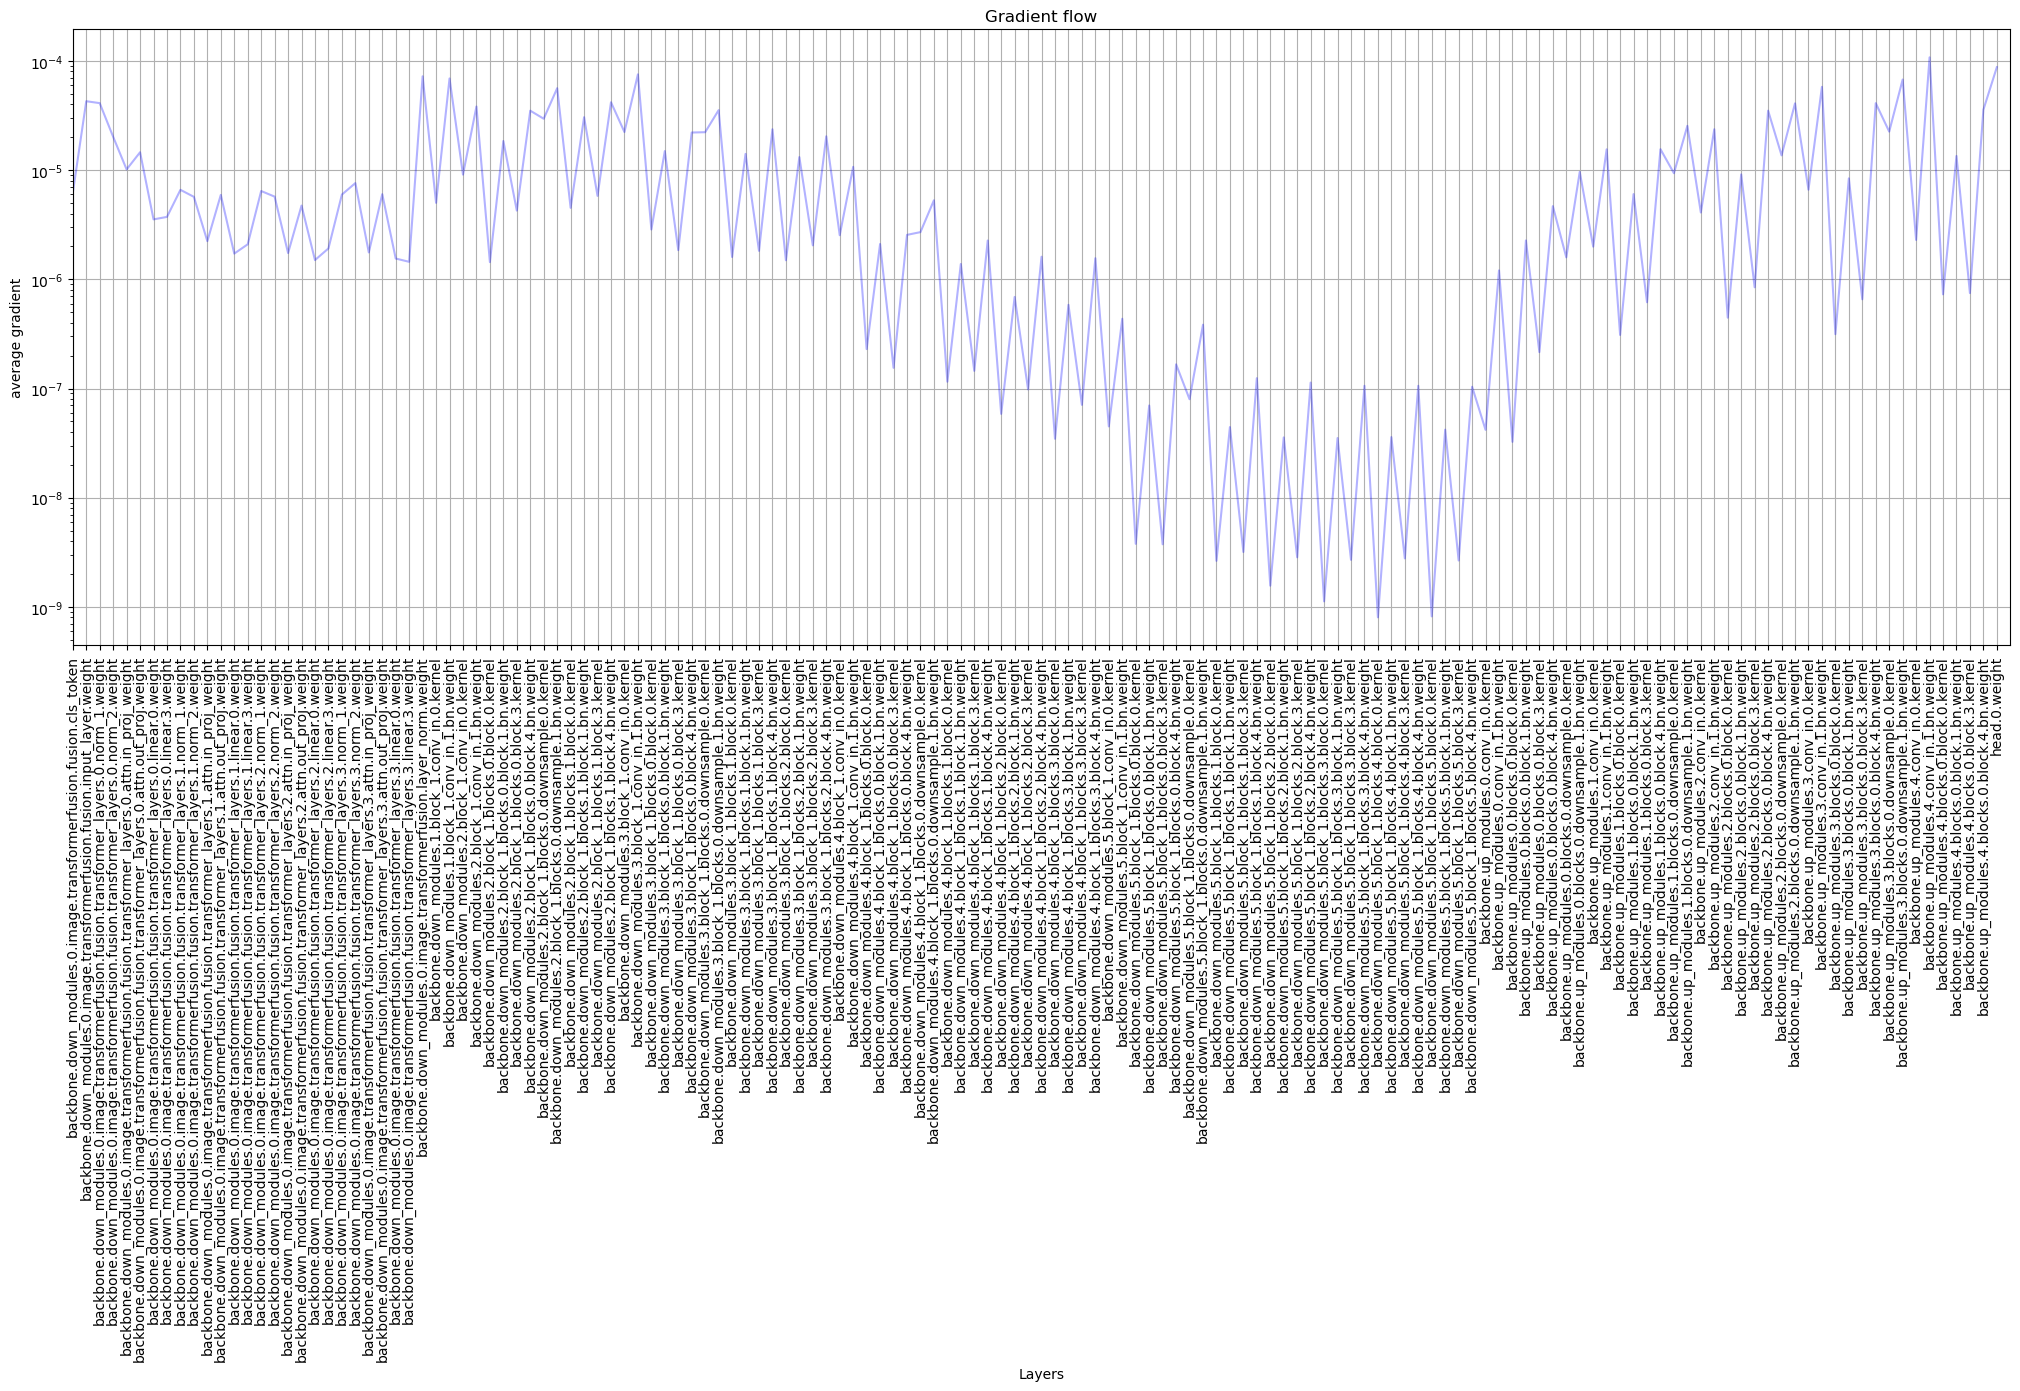

In [5]:
# import pandas as pd
# pd.set_option('display.max_rows', 50)

# # Create validation loader
# dataset.create_dataloaders(
#     model,
#     1,
#     False,
#     17,
#     False,
#     train_only=False,
#     val_only=True,
#     test_batch_size=1
# )

# mapping_idx_to_scan_names = getattr(dataset.val_dataset, "MAPPING_IDX_TO_SCAN_{}_NAMES".format(dataset.val_dataset.split.upper()))
# # print(mapping_idx_to_scan_names)
# # scan_name = mapping_idx_to_scan_names[0]
# # scan_name

# Model playground

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class MyModelA(nn.Module):
    def __init__(self):
        super(MyModelA, self).__init__()
        self.fc1 = nn.Linear(10, 2)
        
    def forward(self, x):
        x = self.fc1(x)
        return x
    

class MyModelB(nn.Module):
    def __init__(self):
        super(MyModelB, self).__init__()
        self.fc1 = nn.Linear(20, 2)
        
    def forward(self, x):
        x = self.fc1(x)
        return x


class MyEnsemble(nn.Module):
    def __init__(self, modelA, modelB):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.classifier = nn.Linear(4, 2)
        
    def forward(self, x1, x2):
        x1 = self.modelA(x1)
        x2 = self.modelB(x2)
        x = torch.cat((x1, x2), dim=1)
        x = self.classifier(F.relu(x))
        return x

# Create models and load state_dicts    
modelA = MyModelA()
modelB = MyModelB()
# Load state dicts
# modelA.load_state_dict(torch.load(PATH))
# modelB.load_state_dict(torch.load(PATH))

model = MyEnsemble(modelA, modelB)
x1, x2 = torch.randn(1, 10), torch.randn(1, 20)
output = model(x1, x2)
output

tensor([[ 0.7763, -0.2771]], grad_fn=<AddmmBackward0>)

In [345]:
import time
import PIL.Image
import torchvision.transforms as transforms

preprocessing = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
    
def load_sample():
    im = Image.open("/scratch-shared/fsun/data/scannet/scans/scene0011_00/color_resized/0.png")
    im = preprocessing(im).unsqueeze(0)
        
    label = Image.open("/scratch-shared/fsun/data/scannet/scans/scene0011_00/label-filt-scannet20/0.png")
    label = torch.tensor(np.asarray(label)).long() - 1   # -1 becomes ignore label
    label = label.unsqueeze(0)
    
    return im, label, None

def train(model, loss_fn, optimizer, load_sample_fn=None, epochs=1, verbose=False):
    start = time.time()
    model.cuda()

    train_loss, valid_loss = [], []

    best_acc = 0.0

    for epoch in range(epochs):
        if verbose:
            print('Epoch {}/{}'.format(epoch, epochs - 1))
            print('-' * 10)

        x, y, image_data = load_sample_fn

        running_loss = 0.0

  
        # zero the gradients
        optimizer.zero_grad()
        
        if image_data is not None:
            outputs = model(x.cuda(), image_data.to('cuda:0'))
        else:
            outputs = model(x.cuda(), None)
                
        loss = loss_fn(outputs, y.cuda())
        
        train_loss.append(loss.item())

        # the backward pass frees the graph memory, so there is no 
        # need for torch.no_grad in this training pass
        loss.backward()
        optimizer.step()
        # scheduler.step()



        # clear_output(wait=True)
        if verbose:
            print('Loss: {}  AllocMem (Mb): {}'.format(loss, torch.cuda.memory_allocated()/1024/1024))
        # print(torch.cuda.memory_summary())


    time_elapsed = time.time() - start
    print("final loss: ", train_loss[-1])
    return train_loss

In [101]:
unet = UNET(3, 20)
loss_fn = nn.CrossEntropyLoss(ignore_index=-1)
optim = torch.optim.Adam(unet.parameters(), lr=0.01)
loss = train(unet, loss_fn, optim, load_sample, epochs=100)

Epoch 0/99
----------
Loss: 2.985055446624756  AllocMem (Mb): 43.68994140625
Epoch 1/99
----------
Loss: 2.732470989227295  AllocMem (Mb): 44.25244140625
Epoch 2/99
----------
Loss: 2.4248251914978027  AllocMem (Mb): 43.68994140625
Epoch 3/99
----------
Loss: 2.1522183418273926  AllocMem (Mb): 44.25244140625
Epoch 4/99
----------
Loss: 1.9302713871002197  AllocMem (Mb): 43.68994140625
Epoch 5/99
----------
Loss: 1.7416588068008423  AllocMem (Mb): 44.25244140625
Epoch 6/99
----------
Loss: 1.5968677997589111  AllocMem (Mb): 43.68994140625
Epoch 7/99
----------
Loss: 1.4866712093353271  AllocMem (Mb): 44.25244140625
Epoch 8/99
----------
Loss: 1.4251577854156494  AllocMem (Mb): 43.68994140625
Epoch 9/99
----------
Loss: 1.3266100883483887  AllocMem (Mb): 44.25244140625
Epoch 10/99
----------
Loss: 1.2584136724472046  AllocMem (Mb): 43.68994140625
Epoch 11/99
----------
Loss: 1.1968885660171509  AllocMem (Mb): 44.25244140625
Epoch 12/99
----------
Loss: 1.1327550411224365  AllocMem (Mb): 

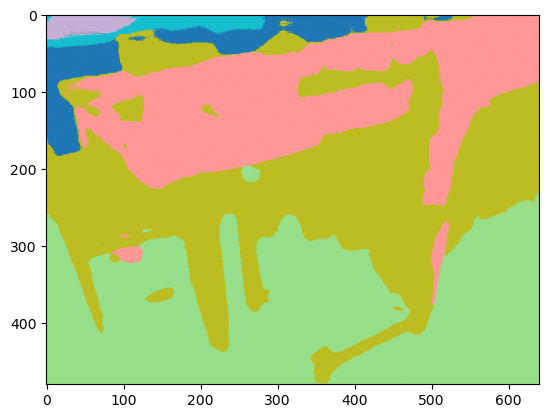

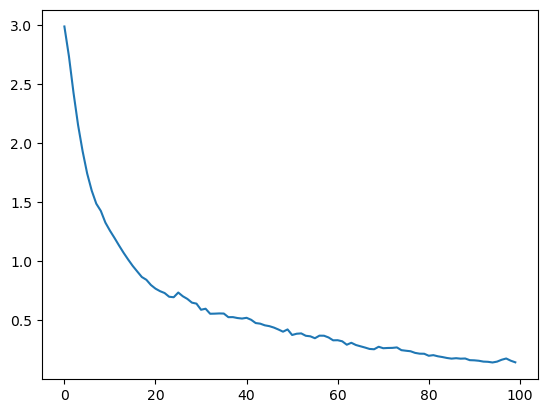

In [102]:
x, y = load_sample()

unet.eval()
with torch.no_grad():
    out_scores = unet(x.cuda())

pred = out_scores.squeeze(0)   # squeeze when bs=1
pred = F.softmax(pred, 0)
pred = pred.argmax(0).cpu()

rgb_pred = np.array(CLASS_COLORS)[pred]

plt.imshow(rgb_pred / 255)
plt.show()

plt.plot(loss)

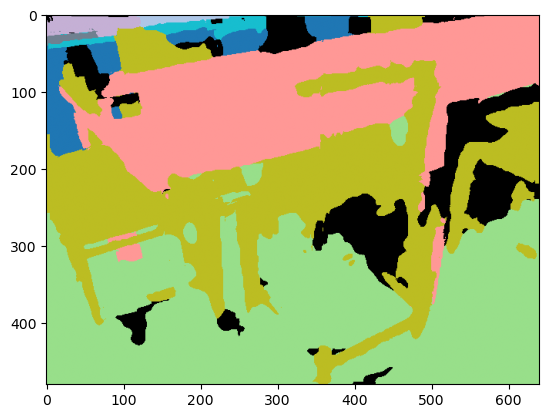

In [9]:
gt_rgb = np.array(CLASS_COLORS)[y[0]] / 255
plt.imshow(gt_rgb)

In [11]:
# plt.plot(loss1, label='0.005')
# plt.plot(loss2, label='0.01')
# plt.legend()
# plt.show()

In [30]:
mm_data = dataset.val_dataset[200]

In [31]:
mm_data

MMData(
    data = Data(coords=[47599, 3], grid_size=[1], id_scan=[1], mapping_index=[47599], mvfusion_input=[38546, 6, 10], origin_id=[47599], pos=[47599, 3], rgb=[47599, 3], x=[47599, 3], y=[47599])
    image = ImageData(num_settings=1, num_views=100, num_points=47599, device=cpu)
)

In [32]:
images = mm_data.modalities['image'][0].x

image_paths = mm_data.modalities['image'][0].path

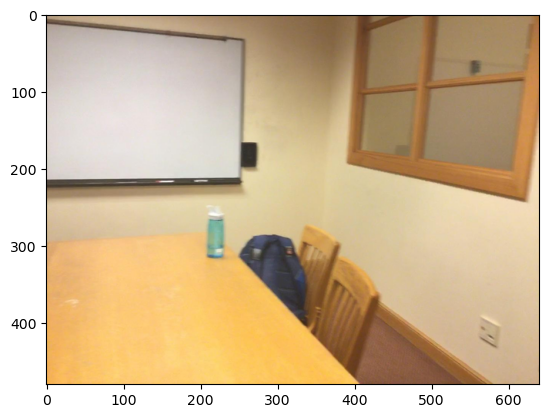

In [38]:
for i in range(1):
    p = image_paths[i]
    p = p.replace("/project", "/scratch-shared").replace("/sens/color", "/color_resized").replace('.jpg', '.png')
    im = Image.open(p)
    plt.imshow(im)

In [325]:
visualize_mm_data(get_seen_points(mm_data), figsize=1000, pointsize=3, voxel=0.05, show_2d=False, back='x', front='y', class_names=CLASS_NAMES, class_colors=CLASS_COLORS, alpha=0.3)

In [315]:
# point1 = 0.54, 1.63, 0.58
# point2 = 1.51, 0.99, -0.6

# between1 = mm_data.x < torch.tensor([1.51, 1.63, 0.58])
# between2 = mm_data.x > torch.tensor([0.54, 0.99, -0.6])

# keep_mask = torch.all(torch.cat((between1, between2), -1), -1)

# subset_data = mm_data[keep_mask]
# visualize_mm_data(subset_data, figsize=1000, pointsize=3, voxel=0.02, show_2d=True, back='x', front='y', class_names=CLASS_NAMES, class_colors=CLASS_COLORS, alpha=0.3)

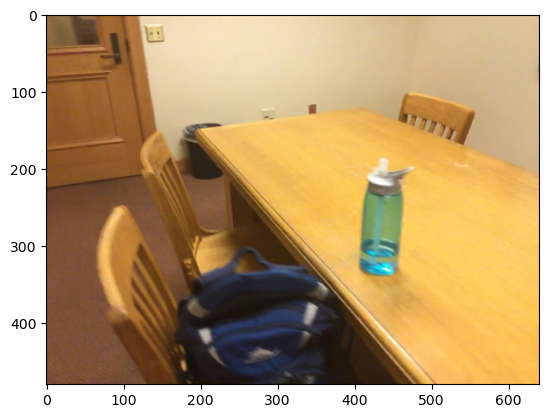

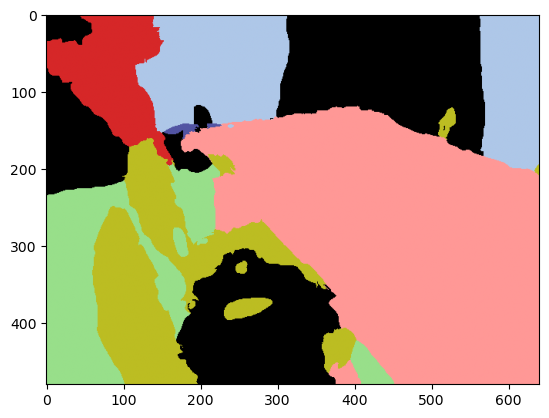

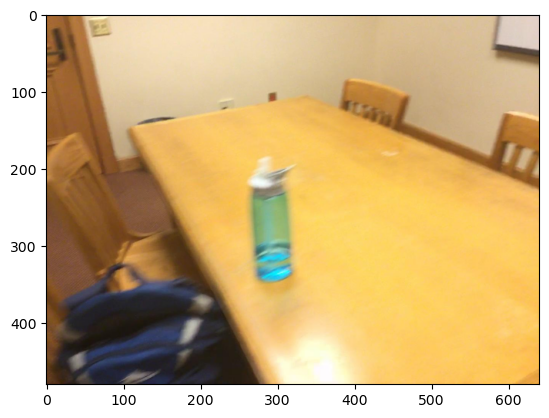

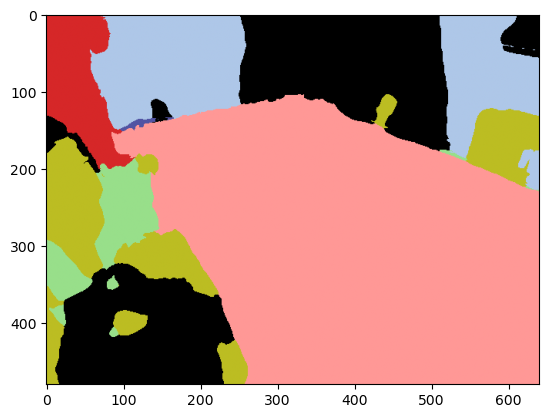

In [326]:
# views = [subset_data.modalities['image'][0][4], subset_data.modalities['image'][0][22]]

view_idx = [38, 64]

mm_data = 

for idx in view_idx:
    v = mm_data.modalities['image'][0][idx]
    p = v.path[0]
    p = p.replace("/project", "/scratch-shared").replace("/sens/color", "/color_resized").replace('.jpg', '.png')
    im = Image.open(p)
    plt.imshow(im)
    plt.show()
    
    
    label = Image.open(v.gt_mask_path[0])
    label = torch.tensor(np.asarray(label)).long() - 1   # -1 becomes ignore label
    label = label.unsqueeze(0)    
    gt_rgb = np.array(CLASS_COLORS)[label[0]] / 255
    plt.imshow(gt_rgb)
    plt.show()
    
# im1 = subset_data.modalities['image'][0][4].x
# gt1 = subset_data.modalities['image'][0][4].gt_mask

# im2 = subset_data.modalities['image'][0][22].x
# gt2 = subset_data.modalities['image'][0][22].gt_mask

In [328]:
from torch import nn
import torch.nn.functional as F

class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)
        
    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

    def forward(self, x, image_data):
        
        if image_data is not None:
        
            # maxpool common features in views
            feature_map = image_data.get_mapped_features()
            csr_idx = image_data.view_csr_indexing

            pooled_features = segment_gather_csr(feature_map, csr_idx, reduce='max')

            x[image_data.feature_map_indexing] = pooled_features
        
        # downsampling part
        conv1 = self.conv1(x)
#         print(f'{x.shape} conv1 ', conv1.shape)
        conv2 = self.conv2(conv1)
#         print(f'{conv1.shape} conv2 ', conv2.shape)
        conv3 = self.conv3(conv2)
#         print(f'{conv2.shape} conv3 ', conv3.shape)

        upconv3 = self.upconv3(conv3)
#         print(f'{conv3.shape} upconv3 ', upconv3.shape)

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
#         print(f'{torch.cat([upconv3, conv2], 1).shape} upconv2 ', upconv2.shape)

        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))
#         print(f'{torch.cat([upconv2, conv1], 1).shape} upconv1 ', upconv1.shape)

        return upconv1



In [329]:
from torch_points3d.modules.multimodal.pooling import segment_gather_csr

feature_map = mm_data.modalities['image'][0][view_idx].get_mapped_features()
csr_idx = mm_data.modalities['image'][0][view_idx].view_csr_indexing


print("feature map: ", feature_map)
pooled_features = segment_gather_csr(feature_map, csr_idx, reduce='max')

y = mm_data.modalities['image'][0][view_idx].x.clone()
print(y.shape)

# feature_map.shape, pooled_features.shape

batch_idx, _, h, w = mm_data.modalities['image'][0][view_idx].feature_map_indexing

y[batch_idx, :, h, w] = pooled_features


torch.equal(mm_data.modalities['image'][0][view_idx].x, y)

feature map:  tensor([[ 0.0741, -0.6001, -1.0898],
        [-0.2856, -0.7752, -1.1421],
        [-0.3369, -0.8627, -1.0550],
        ...,
        [ 0.6906, -0.2150, -0.8981],
        [ 0.7248, -0.2325, -0.8807],
        [ 0.2111, -0.4951, -1.1073]])
torch.Size([2, 3, 240, 320])


False

In [330]:
(csr_idx[1:] - csr_idx[:-1]).unique(return_counts=True)

(tensor([0, 1, 2]), tensor([43855,  1850,  1894]))

In [334]:
def load_sample_multiview(return_image_data=False):
#     view_idx = [5, 22]
    views = mm_data.modalities['image'][0][view_idx]
        
    if return_image_data:
        return views.x, views.gt_mask.squeeze(1), views
    
    
    
    
    
    return views.x, views.gt_mask.squeeze(1), None


def show_sample(use_image_data=False):
    x, y, image_data = load_sample_multiview(use_image_data)

    unet.eval()
    with torch.no_grad():
        if image_data is not None:
            out_scores = unet(x.cuda(), image_data=image_data.to('cuda:0'))
        else:
            out_scores = unet(x.cuda(), image_data=None)

    for i in range(len(view_idx)):
        pred = out_scores[i]  # squeeze when bs=1
        pred = F.softmax(pred, 0)
        pred = pred.argmax(0).cpu()

        rgb_pred = np.array(CLASS_COLORS)[pred]

        plt.imshow(rgb_pred / 255)
        plt.show()

In [348]:
N_EPOCHS = 300

final loss:  0.06608247756958008


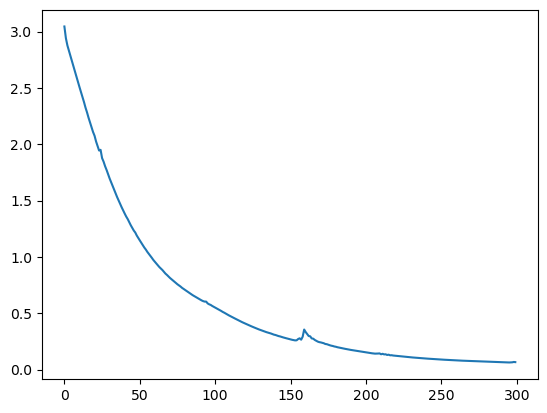

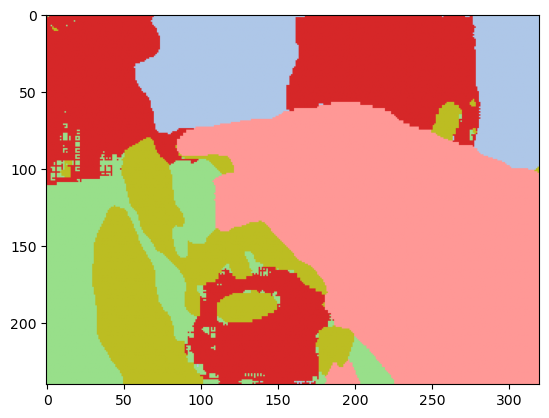

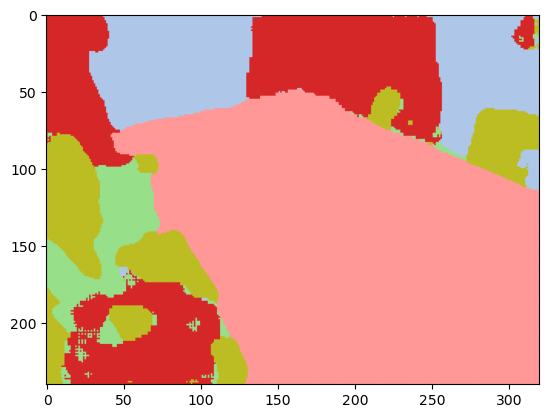

In [351]:
# With feature sharing
unet = UNET(3, 20).cuda()
loss_fn = nn.CrossEntropyLoss(ignore_index=-1)
optim = torch.optim.Adam(unet.parameters(), lr=0.001)
loss = train(unet, loss_fn, optim, load_sample_multiview(False), epochs=N_EPOCHS)

plt.plot(loss)
plt.show()

show_sample(use_image_data=True)

final loss:  0.05336489528417587


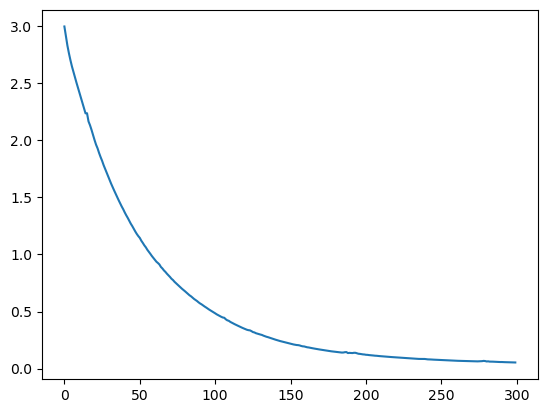

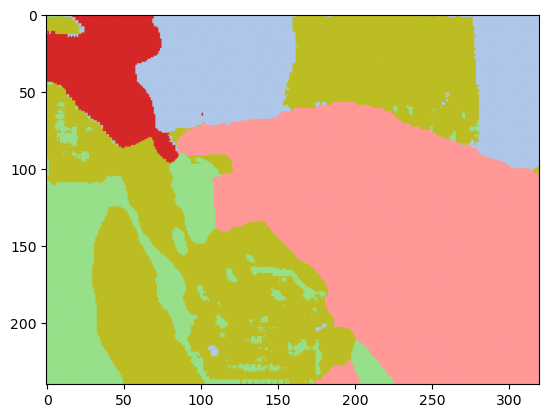

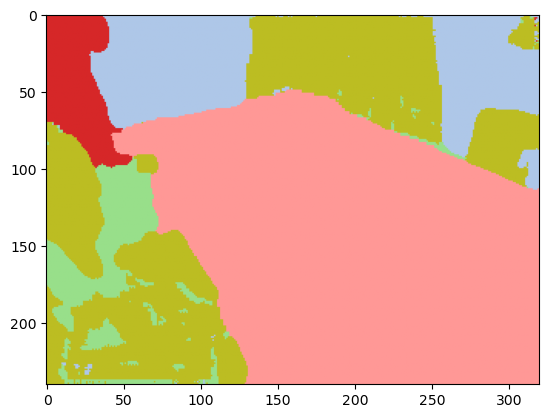

In [352]:
# Baseline UNet
unet = UNET(3, 20).cuda()
loss_fn = nn.CrossEntropyLoss(ignore_index=-1)
optim = torch.optim.Adam(unet.parameters(), lr=0.001)
loss = train(unet, loss_fn, optim, load_sample_multiview(False), epochs=N_EPOCHS)

plt.plot(loss)
plt.show()

show_sample(use_image_data=False)



# Model checkpointing playground

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.checkpoint import checkpoint

def one_step(model, optimizer, return_view_loss=False):
    optimizer.zero_grad()

    out_scores = model(batch)
    
    loss = F.cross_entropy(out_scores, batch.y, ignore_index=-1)
        
    loss.backward()

    # the backward pass frees the graph memory, so there is no 
    # need for torch.no_grad in this training pass
    optimizer.step()
        
    return loss.item()



class MyModelA(nn.Module):
    def __init__(self):
        super(MyModelA, self).__init__()
        self.fc1 = nn.Linear(60, 20)
        
        self.fc2 = nn.Linear(20, 20)
        
        
    def forward(self, mm_data):
        
        x = mm_data.mvfusion_input.flatten(1, 2)
        
        print(x.requires_grad)
        
        x.requires_grad_()
        
        x = self.fc1(x)

        x = checkpoint(self.fc2, x)
    
        print(x.requires_grad)
        

        return x
    

# Create models and load state_dicts    
modelA = MyModelA()

In [57]:
optim = torch.optim.Adam(modelA.parameters(), lr=0.01)

losses = []

In [58]:
s_time = time()


for i in range(1):
    losses.append(one_step(modelA, optim, return_view_loss=True))

print("100 iterations duration: ", time() - s_time)



False
True
100 iterations duration:  0.03126025199890137


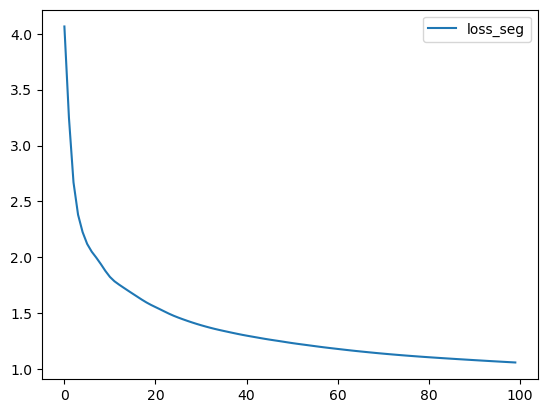

In [16]:
plt.plot(losses, label='loss_seg')
# plt.plot(loss_cross_entropy, label='loss_cross_entropy')
# plt.plot(loss_view_fusion, label='loss_view_fusion')

ax = plt.gca()
# ax.set_ylim([0.0, 1.0])

plt.legend()
plt.show()

# Code to touch every file

In [6]:
# import os
# import re
# import concurrent.futures

# from pathlib import Path

# import time

# s_time = time.time()

# search_dirs = ["/scratch-shared/fsun"]

# file_list = []

# for topdir in search_dirs:
#     for root, dirs, files in os.walk(topdir):
                
#         for file in files:
            
#             p = os.path.join(root, file)
                        
#             file_list.append(p)

# print("collected all files in ", time.time() - s_time)
            
# def toucher(path):
#     Path(path).touch()
#     return path

# # We can use a with statement to ensure threads are cleaned up promptly
# with concurrent.futures.ThreadPoolExecutor(max_workers=32) as executor:
#     # Start the load operations and mark each future with its URL
#     future_to_url = {executor.submit(toucher, path): path for path in file_list}
#     for future in concurrent.futures.as_completed(future_to_url):
#         url = future_to_url[future]
#         try:
#             data = future.result()
#         except Exception as exc:
#             print(f'{data} generated an exception')


# print("Duration: ", time.time() - s_time)

In [6]:
s = {0: '89.92', 1: '98.15', 2: '74.04', 3: '86.25', 4: '93.95', 5: '87.01', 6: '82.39', 7: '77.76', 8: '75.23', 9: '78.95', 10: '30.47', 11: '69.04', 12: '75.62', 13: '82.36', 14: '79.51', 15: '85.12', 16: '96.03', 17: '70.43', 18: '90.06', 19: '70.81'}

l = []
for k, v in s.items():
    l.append(str(np.round(float(v), 1)))
" & ".join(l)

'89.9 & 98.2 & 74.0 & 86.2 & 94.0 & 87.0 & 82.4 & 77.8 & 75.2 & 79.0 & 30.5 & 69.0 & 75.6 & 82.4 & 79.5 & 85.1 & 96.0 & 70.4 & 90.1 & 70.8'